<a href="https://colab.research.google.com/github/ris0801/Generalization-DeepLearning/blob/main/CompleteCode_AdvancedProject_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
import seaborn as sns
from captum.attr import IntegratedGradients
from sklearn.metrics import confusion_matrix
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cuda


##CNN architecture as mentioned in paper

In [4]:
class SimpleCNNWithHooks(nn.Module):
    def __init__(self):
        super(SimpleCNNWithHooks, self).__init__()
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=200, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(200)
        self.conv2 = nn.Conv2d(in_channels=200, out_channels=200, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(200)
        # Fully connected layers
        self.fc1 = nn.Linear(200 * 7 * 7, 384)
        self.bn3 = nn.BatchNorm1d(384)
        self.fc2 = nn.Linear(384, 192)
        self.bn4 = nn.BatchNorm1d(192)
        self.fc3 = nn.Linear(192, 10)
        self.activations = {}

    def forward(self, x):

        x = x[:, :, 2:-2, 2:-2]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        # Save activations
        self.activations['conv1'] = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        # Save activations
        self.activations['conv2'] = x
        x = x.view(-1, 200 * 7 * 7)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x


#Working with CIFAR10 data

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [00:01<00:00, 104324998.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


### Getting probability distribution
How well a machine learning model has learned to predict the correct outputs for the inputs it was trained on

In [6]:
def estimated_p_correct(model, loader):
    correct = np.zeros(len(loader.dataset))
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct[batch_idx * loader.batch_size:batch_idx * loader.batch_size + len(data)] = pred.eq(target).cpu().numpy().astype(int)
    return correct

### Plotting weight distribution
Visual presentation of distribution of weights

In [7]:
def plot_weight_distribution(weights, title):
    weights_flat = weights.cpu().numpy().flatten()
    plt.figure(figsize=(10, 5))
    sns.histplot(weights_flat, bins=50, kde=True)
    plt.title(title)
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

### Visualizing weights

In [8]:
def visualize_weights(weights):
    weights = weights.cpu().numpy()
    num_filters = weights.shape[0]
    num_cols = int(np.sqrt(num_filters))
    num_rows = int(np.ceil(num_filters / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i in range(num_filters):
        ax = axes[i // num_cols, i % num_cols]
        filter_weights = weights[i, 0, :, :]

        filter_weights = (filter_weights - filter_weights.min()) / (filter_weights.max() - filter_weights.min())

        ax.imshow(filter_weights, cmap='gray')
        ax.axis('off')

    plt.show()

### Plotting attributions

**What are attributions** : How different parts of the input contribute to the model's output. For deep learning models, especially for images, attributions can highlight regions of an image that are influential in making a particular classification or prediction.



In [9]:
def calculate_and_plot_attributions(model, input_image, true_label):
    model.eval()

    ig = IntegratedGradients(model)

    attributions, delta = ig.attribute(input_image, target=true_label, return_convergence_delta=True)

    input_image_np = input_image.squeeze(0).cpu().numpy()
    attributions_np = attributions.squeeze(0).cpu().numpy()

    if input_image_np.shape[0] == 1:
        plt.imshow(input_image_np[0], cmap='gray')
    else:
        plt.imshow(input_image_np.transpose(1, 2, 0))
    plt.title("Input Image")
    plt.show()

    if attributions_np.shape[0] == 1:
        plt.imshow(attributions_np[0], cmap='gray')
    else:
        plt.imshow(attributions_np.transpose(1, 2, 0))
    plt.title("Attributions")
    plt.show()

    print("Convergence Delta:", delta)

###Function for visulazing the weights of first layer

In [10]:
def visualize_weights(weights, img_dim=(8, 8), n_rows=5, n_cols=5, channel_idx=0):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i][j]

            weight = weights[i * n_cols + j].detach().cpu().numpy()
            weight = weight.reshape(32, 8, 8)[channel_idx]

            weight = (weight - weight.min()) / (weight.max() - weight.min())

            ax.imshow(weight, cmap='gray')
            ax.axis('off')

    plt.show()

### Visualizing feature maps

In [11]:
def visualize_feature_maps(activation, num_columns=6):

    num_kernels = activation.size(1)
    num_rows = int(np.ceil(num_kernels / num_columns))
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))

    for i in range(num_rows):
        for j in range(num_columns):
            if i * num_columns + j < num_kernels:
                ax = axes[i, j]
                ax.imshow(activation[0][i * num_columns + j].detach().cpu().numpy(), cmap='viridis')
                ax.axis('off')
            else:
                axes[i, j].remove()

    plt.show()

In [12]:
def calculate_mean_variance(activation):
    activation_np = activation.detach().cpu().numpy()
    mean = np.mean(activation_np)
    variance = np.var(activation_np)
    return mean, variance

In [13]:
def svcca_analysis(activations1, activations2):
    # Clone and detach tensors if they are already PyTorch tensors
    activations1 = activations1.clone().detach()
    activations2 = activations2.clone().detach()

    # Mean centering the activations
    activations1 -= torch.mean(activations1, axis=0)
    activations2 -= torch.mean(activations2, axis=0)

    # Singular Value Decomposition (SVD)
    U1, _, _ = torch.linalg.svd(activations1, full_matrices=False)
    U2, _, _ = torch.linalg.svd(activations2, full_matrices=False)

    # Ensure the dimensions are compatible for matrix multiplication
    # For instance, you may need to transpose or reshape tensors
    cca = torch.matmul(U1.T, U2)

    svcca_result = torch.diag(cca).cpu().numpy()  # Convert to numpy array if needed

    return svcca_result


In [14]:
from scipy.stats import skew, kurtosis

def calculate_skewness_kurtosis(activation):
    activation_np = activation.detach().cpu().numpy().flatten()
    skewness = skew(activation_np)
    kurtosis_val = kurtosis(activation_np)
    return skewness, kurtosis_val

In [15]:
def calculate_sparsity(activation, threshold=1e-5):
    activation_np = activation.detach().cpu().numpy()
    sparsity = np.mean(activation_np < threshold)
    return sparsity

In [16]:
def get_predictions(model, loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

In [17]:
from collections import defaultdict
def create_balanced_subset(dataset, num_per_class=100):
    class_counts = defaultdict(int)
    subset_indices = []

    for i, (_, target) in enumerate(dataset):
        if class_counts[target] < num_per_class:
            subset_indices.append(i)
            class_counts[target] += 1
            if all(count == num_per_class for count in class_counts.values()):
                break

    return torch.utils.data.Subset(dataset, subset_indices)

In [18]:
def estimated_p_correct(model, subset_loader):
    model.eval()
    correct_counts = [0] * 10  # Assuming 10 classes
    total_counts = [0] * 10

    with torch.no_grad():
        for data, target in subset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            for label, prediction in zip(target, predicted):
                total_counts[label] += 1
                correct_counts[label] += (prediction == label).item()

    return correct_counts, total_counts

In [19]:
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total




### Working with actual data

In [20]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [21]:
import numpy as np

subset_size = 1024

np.random.seed(42)
subset_indices = np.random.choice(len(train_dataset), subset_size, replace=False)


In [22]:
from torch.utils.data import Subset

# Subset for actual data
actual_subset = Subset(train_dataset, subset_indices)
actual_loader = torch.utils.data.DataLoader(actual_subset, batch_size=64, shuffle=True)

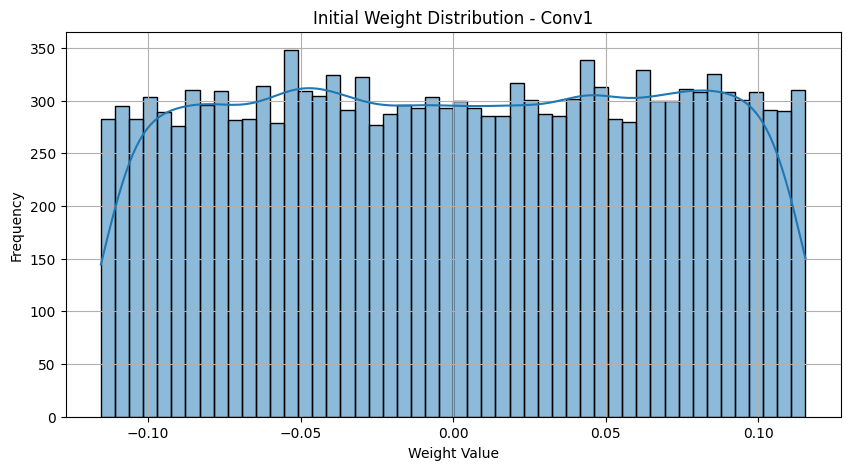

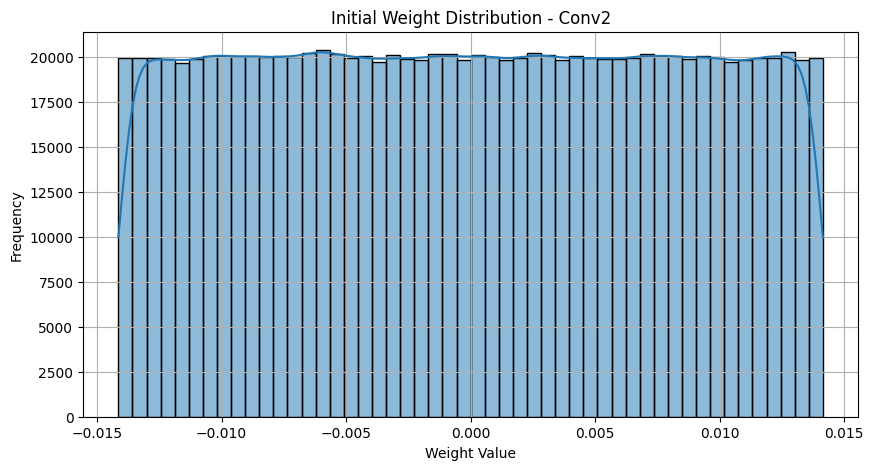

Statistics of the weights For Conv1:
Mean: 0.0007005322258919477
Standard Deviation: 0.06658350676298141
Minimum: -0.11546610295772552
Maximum: 0.11545723676681519


Statistics of the weights for Conv2:
Mean: -3.1491226764046587e-06
Standard Deviation: 0.00815980602055788
Minimum: -0.014142077416181564
Maximum: 0.014142059721052647


Files already downloaded and verified
Analysis after epoch 1




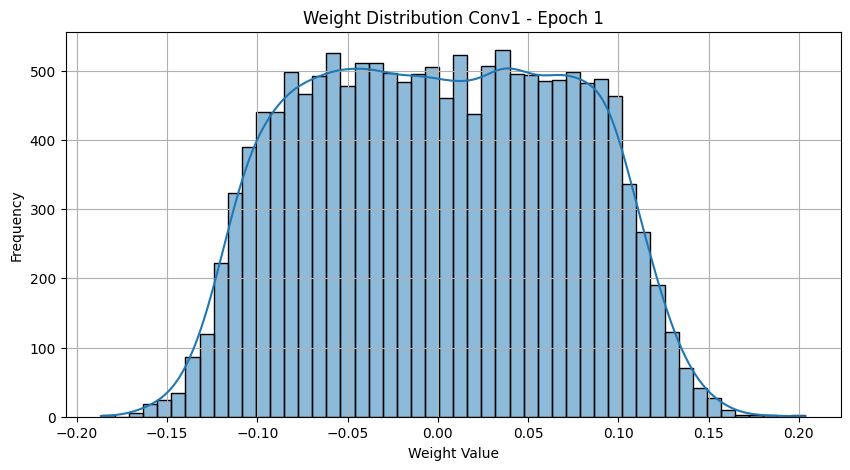

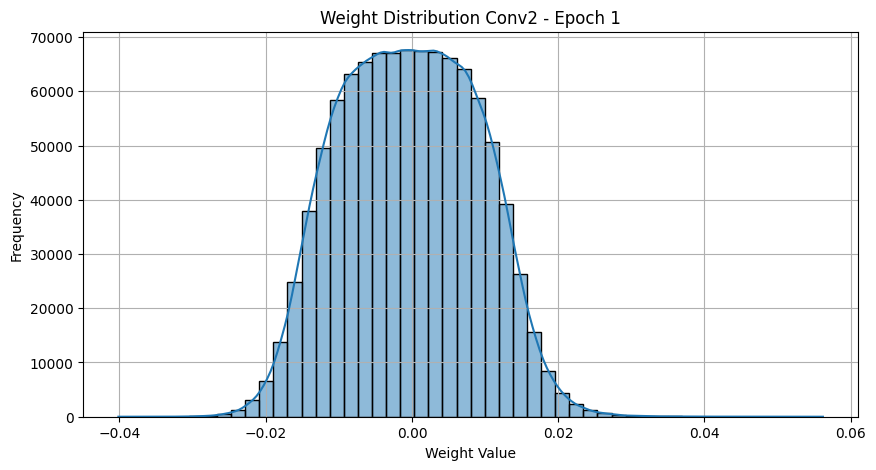

Statistics of the weights For Conv1:
Mean: -0.00014416348130907863
Standard Deviation: 0.07081981003284454
Minimum: -0.18673761188983917
Maximum: 0.2036902904510498


Statistics of the weights for Conv2:
Mean: -0.0004004135844297707
Standard Deviation: 0.009317968972027302
Minimum: -0.040145598351955414
Maximum: 0.05620025470852852




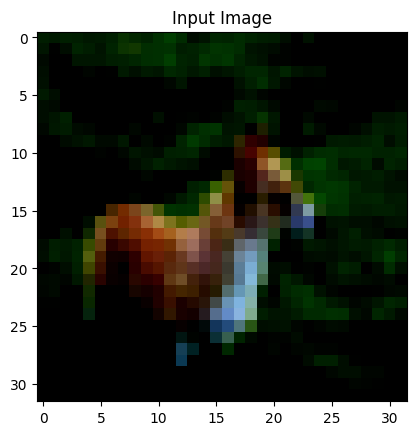

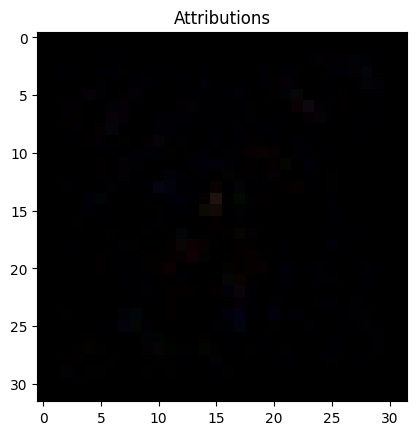

Convergence Delta: tensor([-0.0015], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.8533949255943298
Variance: 0.7059309482574463
Skewness: 1.2646529337678027
Kurtosis: 2.0317211923703633
Sparsity: 0.20073341836734693


Analysis for layer: conv2
Mean: 0.7768330574035645
Variance: 0.5695018768310547
Skewness: 1.2363521755236162
Kurtosis: 2.5186268639281844
Sparsity: 0.22874202806122448








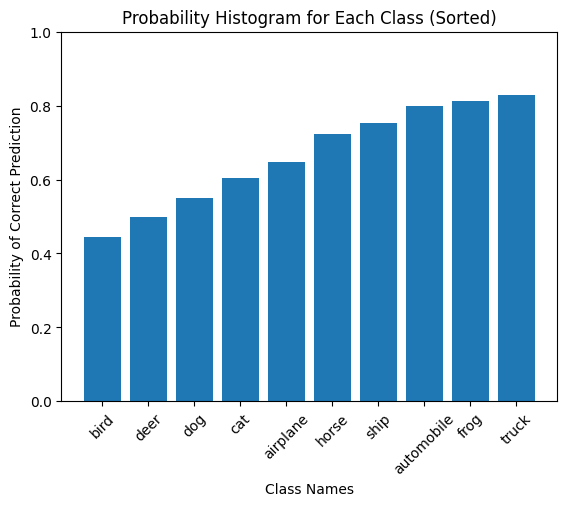



Accuracy on the test set after the final epoch: 66.58%
Analysis after epoch 5




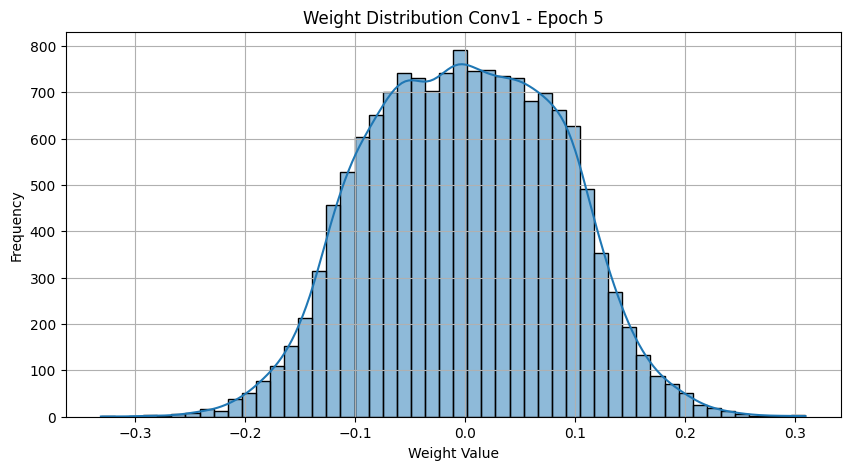

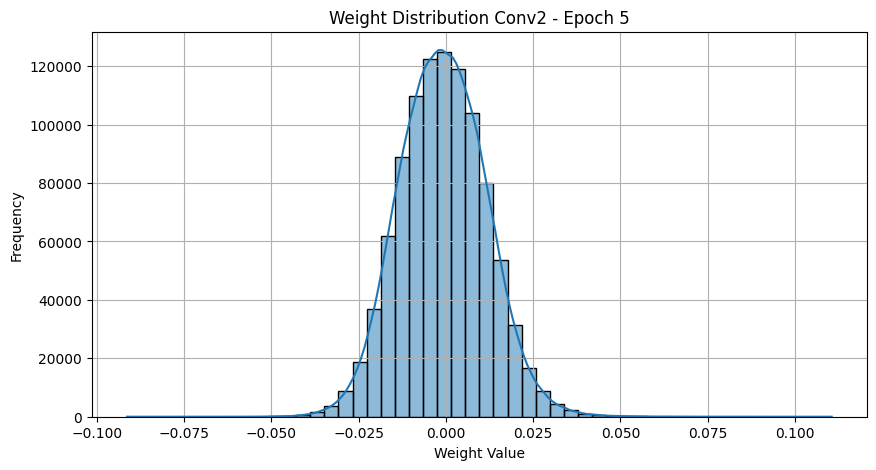

Statistics of the weights For Conv1:
Mean: -0.0004413202404975891
Standard Deviation: 0.08603539317846298
Minimum: -0.33112749457359314
Maximum: 0.3094058334827423


Statistics of the weights for Conv2:
Mean: -0.0008391816518269479
Standard Deviation: 0.012415846809744835
Minimum: -0.09131360054016113
Maximum: 0.1105419248342514




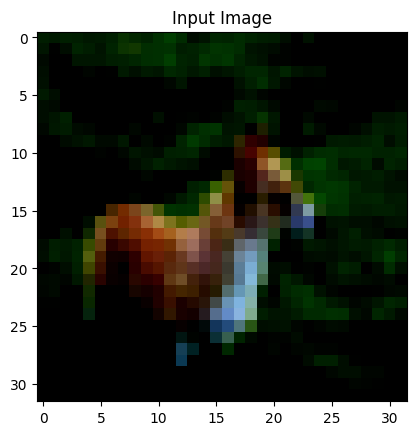

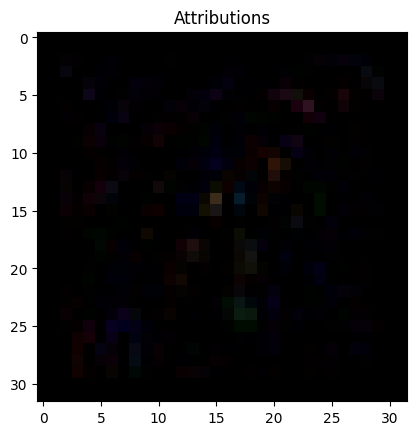

Convergence Delta: tensor([0.0007], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.8318354487419128
Variance: 0.7623223066329956
Skewness: 1.5583388310336823
Kurtosis: 3.5418006303403056
Sparsity: 0.21250996492346938


Analysis for layer: conv2
Mean: 0.7519795298576355
Variance: 0.49583590030670166
Skewness: 1.2955005977915224
Kurtosis: 3.2130088286144227
Sparsity: 0.20425542091836735








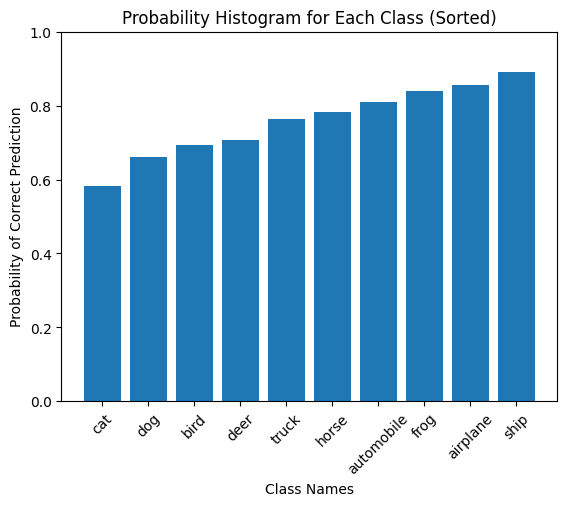



Accuracy on the test set after the final epoch: 75.89%
Analysis after epoch 10




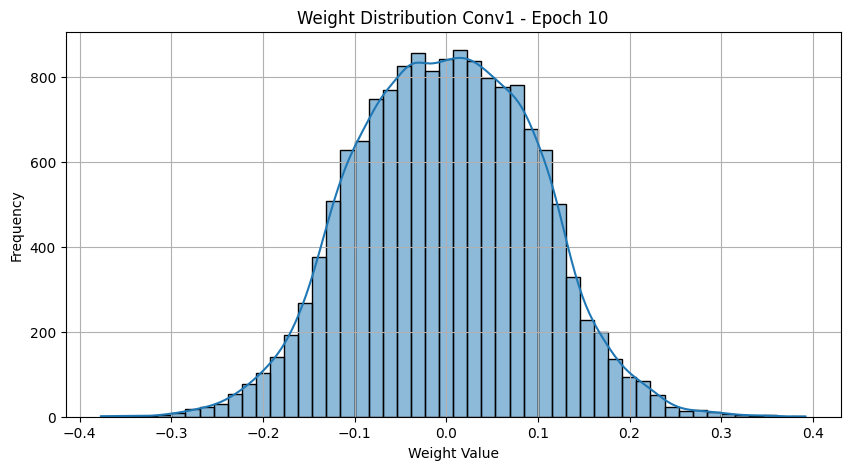

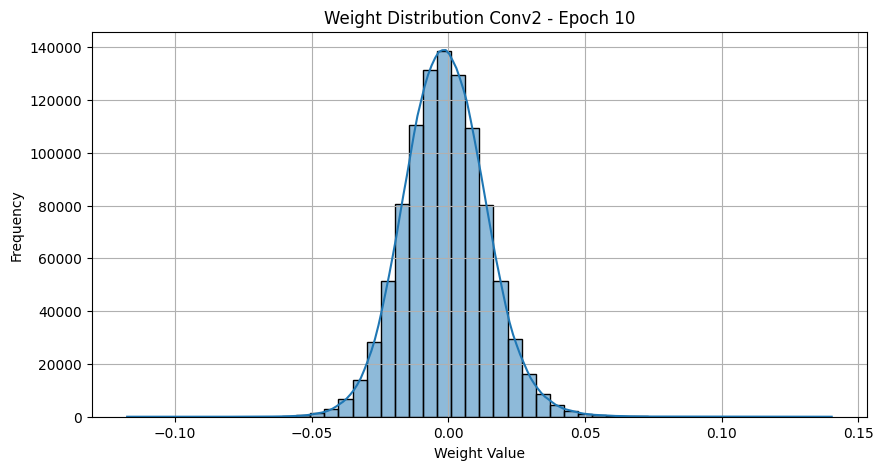

Statistics of the weights For Conv1:
Mean: -0.0008439837256446481
Standard Deviation: 0.09689578413963318
Minimum: -0.376746267080307
Maximum: 0.39189743995666504


Statistics of the weights for Conv2:
Mean: -0.0011749609839171171
Standard Deviation: 0.015112555585801601
Minimum: -0.11752358824014664
Maximum: 0.14023004472255707




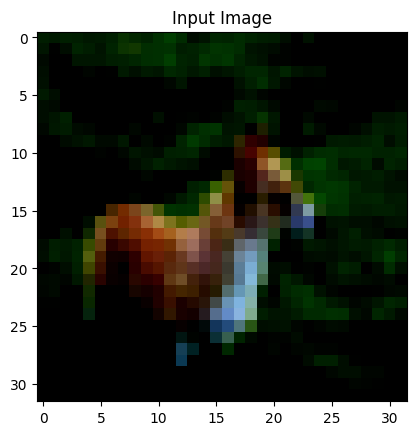

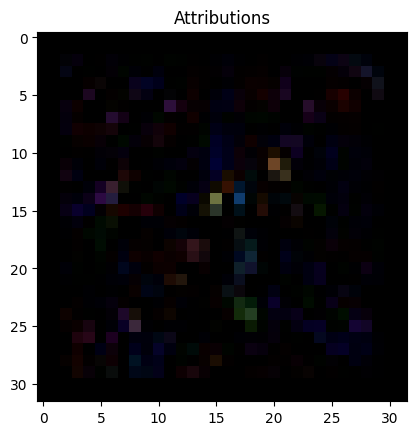

Convergence Delta: tensor([0.0402], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.8144630193710327
Variance: 0.7593288421630859
Skewness: 1.7464280919058948
Kurtosis: 4.803841644385757
Sparsity: 0.20126076211734695


Analysis for layer: conv2
Mean: 0.6971380710601807
Variance: 0.43133166432380676
Skewness: 1.2570209698794463
Kurtosis: 2.6868661144688666
Sparsity: 0.21130899234693878








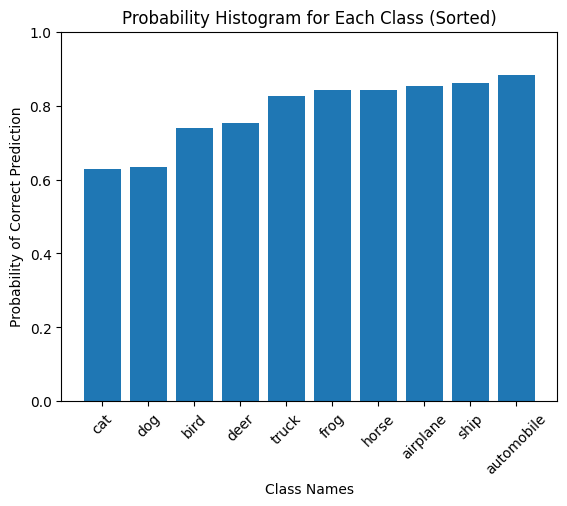



Accuracy on the test set after the final epoch: 78.58%
Analysis after epoch 15




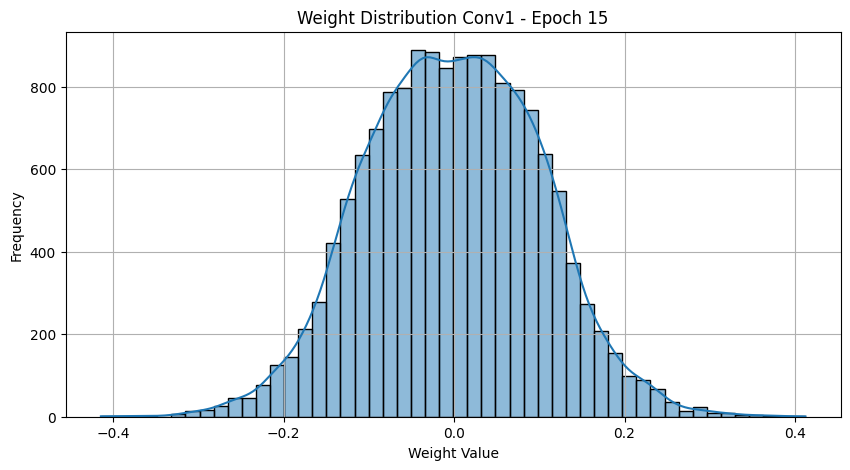

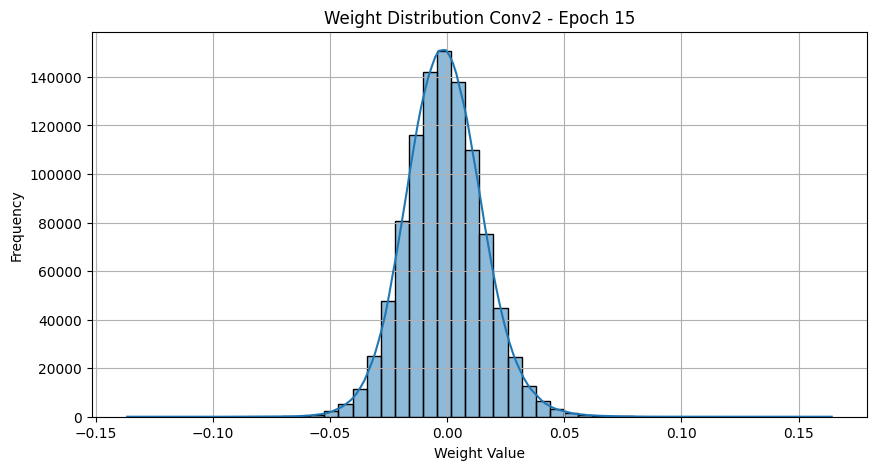

Statistics of the weights For Conv1:
Mean: -0.0009578884346410632
Standard Deviation: 0.10200273245573044
Minimum: -0.4142868220806122
Maximum: 0.4121924936771393


Statistics of the weights for Conv2:
Mean: -0.0013094003079459071
Standard Deviation: 0.01646558940410614
Minimum: -0.136673241853714
Maximum: 0.1641567051410675




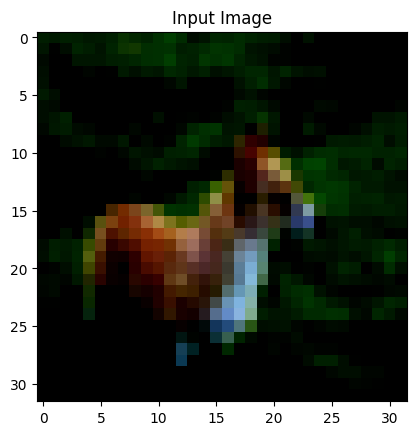

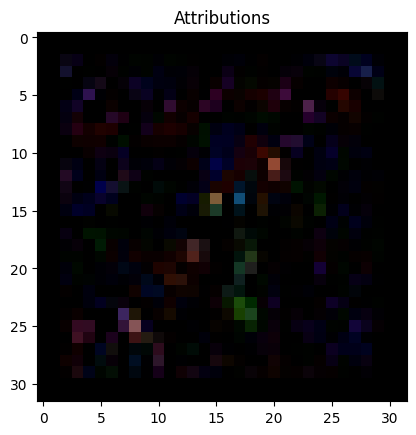

Convergence Delta: tensor([0.0287], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.8150318264961243
Variance: 0.7732237577438354
Skewness: 1.6542194209343728
Kurtosis: 4.053072415270524
Sparsity: 0.21319595025510205


Analysis for layer: conv2
Mean: 0.6730563640594482
Variance: 0.40975701808929443
Skewness: 1.240535412574991
Kurtosis: 2.6616842826113523
Sparsity: 0.2210076530612245








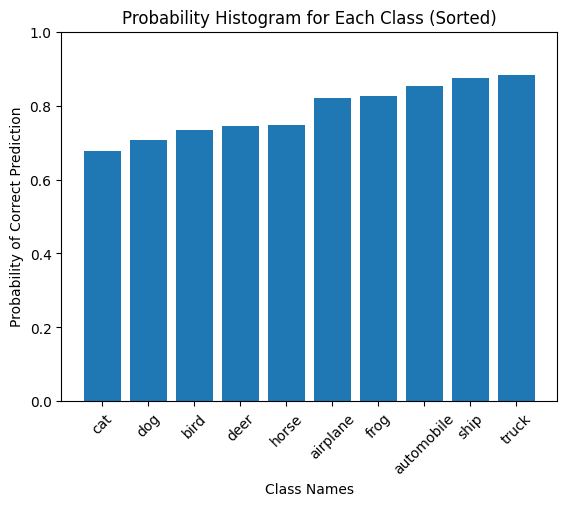



Accuracy on the test set after the final epoch: 78.66%
Analysis after epoch 20




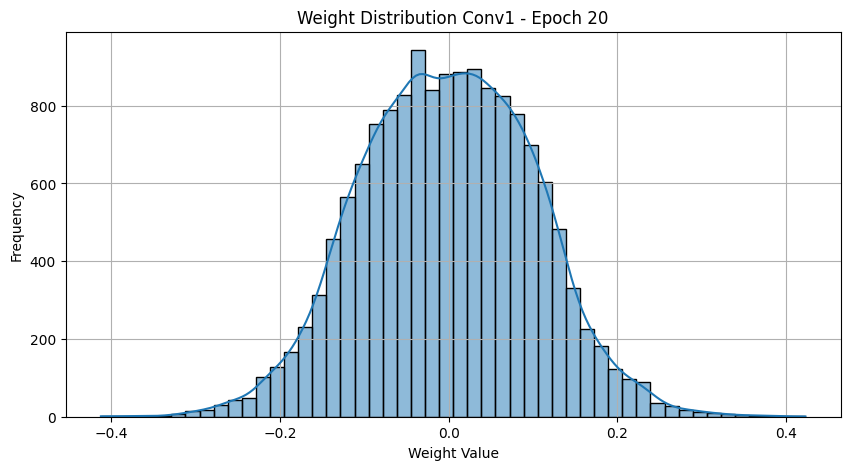

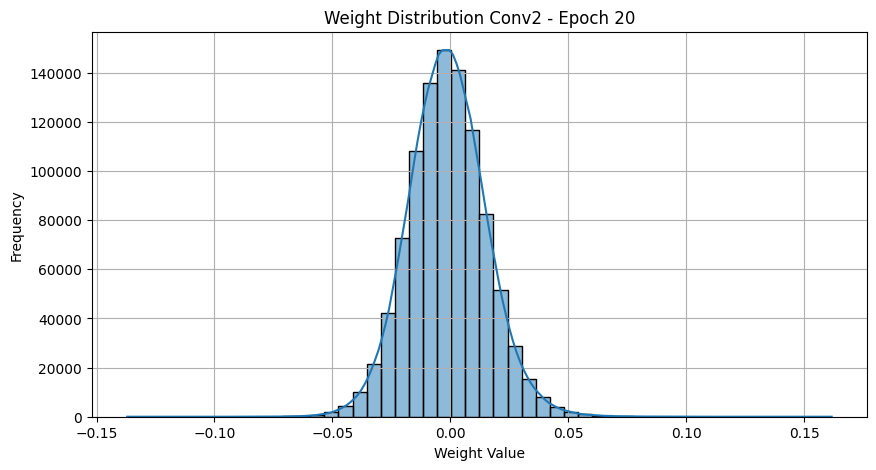

Statistics of the weights For Conv1:
Mean: -0.0008799320203252137
Standard Deviation: 0.10214950889348984
Minimum: -0.4124373495578766
Maximum: 0.4232998192310333


Statistics of the weights for Conv2:
Mean: -0.0013252581702545285
Standard Deviation: 0.01650494895875454
Minimum: -0.13702203333377838
Maximum: 0.16154667735099792




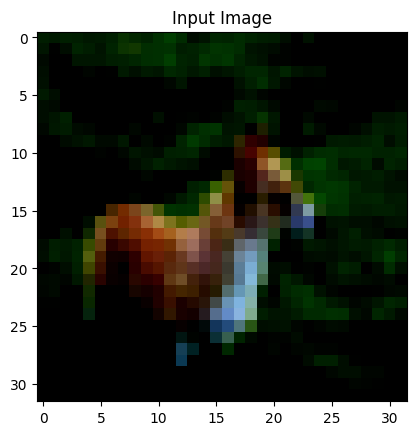

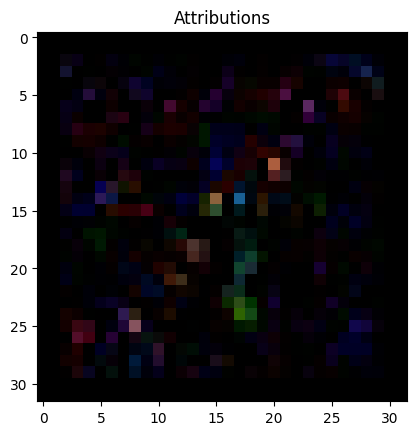

Convergence Delta: tensor([-0.0611], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.7941060662269592
Variance: 0.7112656235694885
Skewness: 1.8020722795858601
Kurtosis: 5.584566405619453
Sparsity: 0.2000685586734694


Analysis for layer: conv2
Mean: 0.6633157134056091
Variance: 0.39016738533973694
Skewness: 1.301966763703492
Kurtosis: 3.222895059821221
Sparsity: 0.2081951530612245








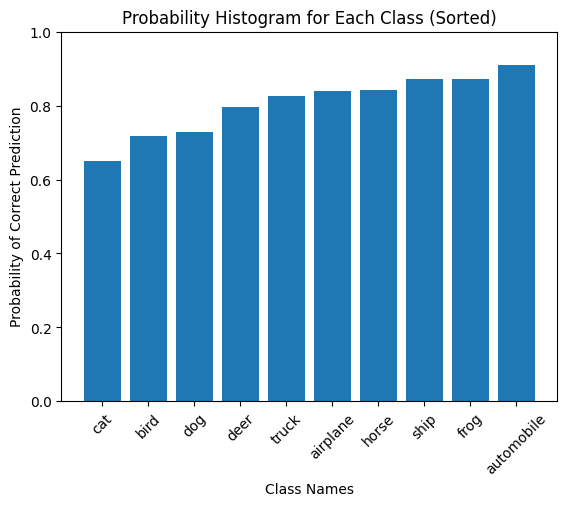



Accuracy on the test set after the final epoch: 80.55%
Analysis after epoch 25




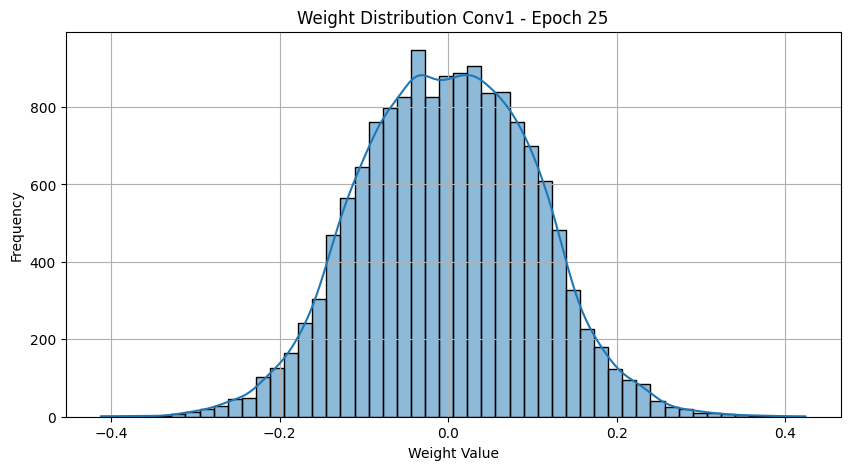

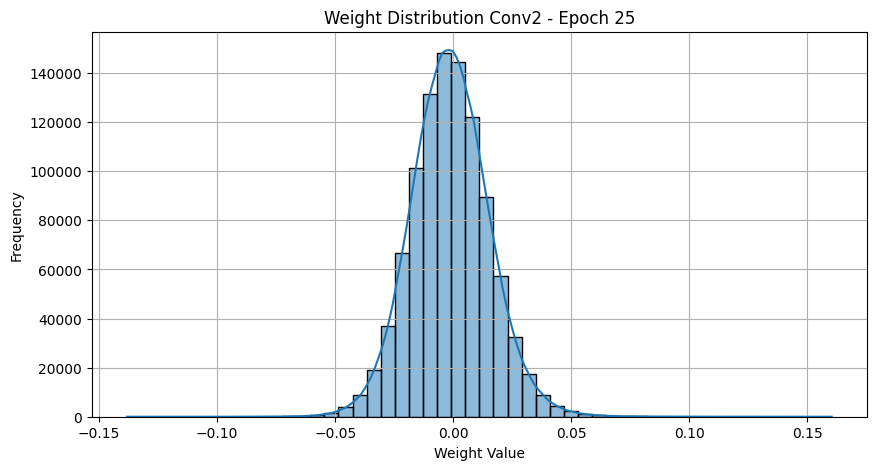

Statistics of the weights For Conv1:
Mean: -0.0008844014373607934
Standard Deviation: 0.10218571126461029
Minimum: -0.4122079908847809
Maximum: 0.42387616634368896


Statistics of the weights for Conv2:
Mean: -0.0013415605062618852
Standard Deviation: 0.016513347625732422
Minimum: -0.13816043734550476
Maximum: 0.16031572222709656




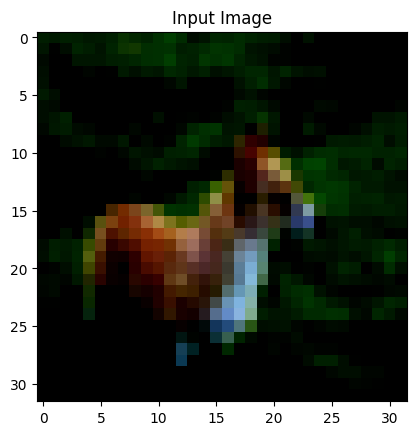

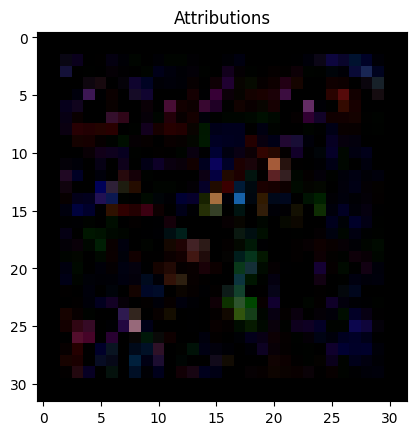

Convergence Delta: tensor([0.0475], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.815872848033905
Variance: 0.7512847781181335
Skewness: 1.7193505961502804
Kurtosis: 4.713444967178869
Sparsity: 0.20507254464285715


Analysis for layer: conv2
Mean: 0.6502946615219116
Variance: 0.38719773292541504
Skewness: 1.2476962601521349
Kurtosis: 2.570726034190165
Sparsity: 0.22097098214285715








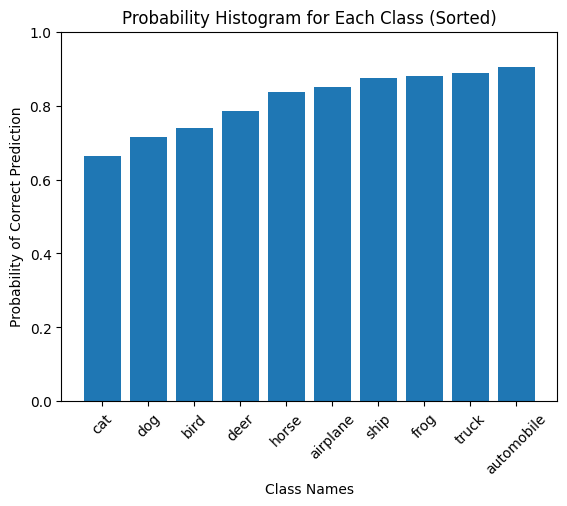



Accuracy on the test set after the final epoch: 81.39%
Analysis after epoch 30




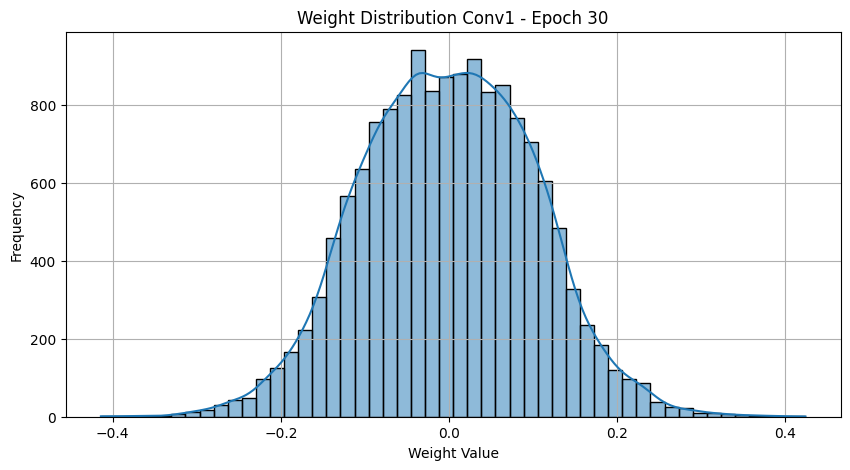

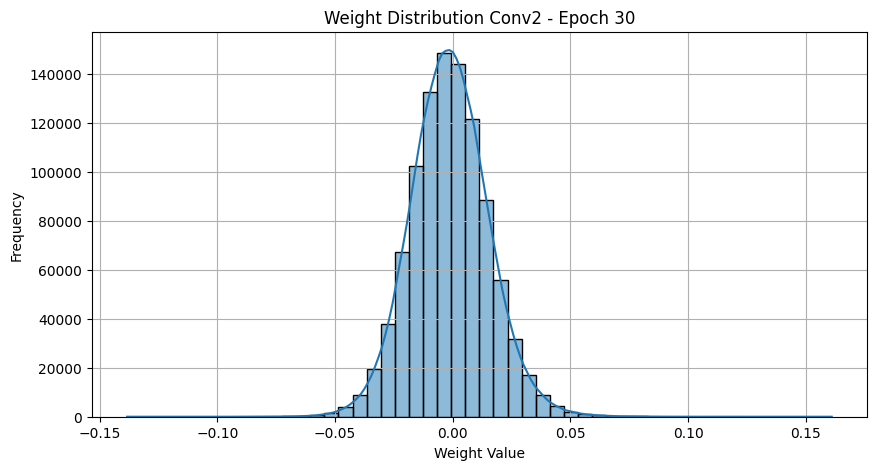

Statistics of the weights For Conv1:
Mean: -0.0008829575381241739
Standard Deviation: 0.10221683979034424
Minimum: -0.41396117210388184
Maximum: 0.42382729053497314


Statistics of the weights for Conv2:
Mean: -0.0013383233454078436
Standard Deviation: 0.01652190089225769
Minimum: -0.13837124407291412
Maximum: 0.16099002957344055




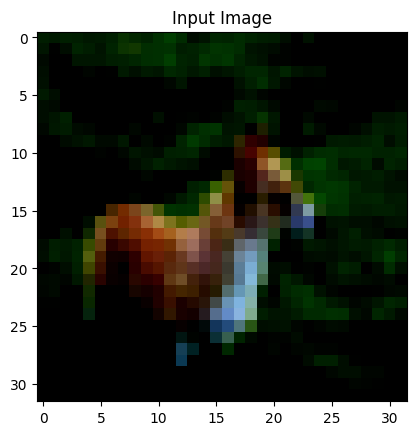

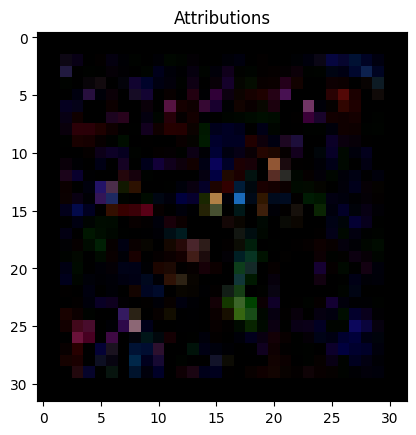

Convergence Delta: tensor([0.0906], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.7925155162811279
Variance: 0.6943771243095398
Skewness: 1.7273979517167892
Kurtosis: 4.72165329134422
Sparsity: 0.19211176658163265


Analysis for layer: conv2
Mean: 0.6574395895004272
Variance: 0.3704790472984314
Skewness: 1.179321903027957
Kurtosis: 2.347815199262528
Sparsity: 0.2062627551020408








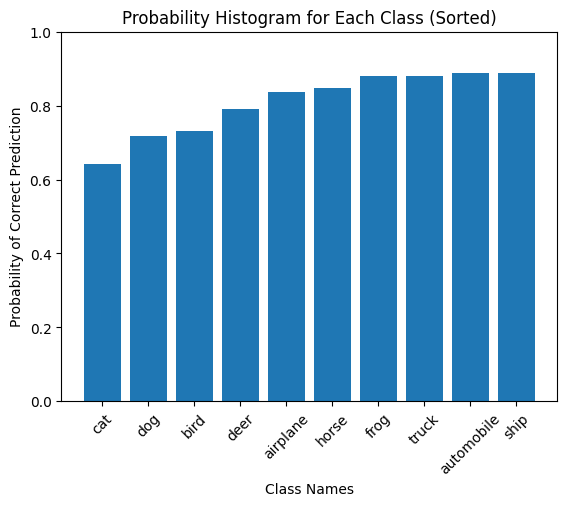



Accuracy on the test set after the final epoch: 81.07%


In [23]:
num_initializations = 1

for _ in range(num_initializations):
    sample_data, sample_target = next(iter(train_loader))
    sample_data, sample_target = sample_data.to(device), sample_target.to(device)
    input_image = sample_data[0:1]  # Single image with batch dimension
    true_label = sample_target[0].item()

    model1 = SimpleCNNWithHooks().to(device)
    optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

    # Visualize initial weight distribution for conv1
    initial_weights_conv1 = model1.conv1.weight.data
    plot_weight_distribution(initial_weights_conv1, "Initial Weight Distribution - Conv1")

    # Visualize initial weight distribution for conv2
    initial_weights_conv2 = model1.conv2.weight.data
    plot_weight_distribution(initial_weights_conv2, "Initial Weight Distribution - Conv2")

    weights = model1.conv1.weight.data
    weightsConv2 = model1.conv2.weight.data

    mean = weights.mean().item()
    std = weights.std().item()
    min_val = weights.min().item()
    max_val = weights.max().item()

    print("Statistics of the weights For Conv1:")
    print("Mean:", mean)
    print("Standard Deviation:", std)
    print("Minimum:", min_val)
    print("Maximum:", max_val)
    print("\n")

    mean = weightsConv2.mean().item()
    std = weightsConv2.std().item()
    min_val = weightsConv2.min().item()
    max_val = weightsConv2.max().item()

    print("Statistics of the weights for Conv2:")
    print("Mean:", mean)
    print("Standard Deviation:", std)
    print("Minimum:", min_val)
    print("Maximum:", max_val)
    print("\n")

    val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


    for epoch in range(30):
      model1.train()
      for data, target in train_loader:
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model1(data)
          loss = nn.CrossEntropyLoss()(output, target)
          loss.backward()
          optimizer.step()

      if epoch==0 or (epoch+1)%10==0:
        # Save activations
        model1.eval()
        activations = {}
        with torch.no_grad():
            for data, _ in actual_loader:  # Consider using a subset of data if full dataset is too large
                data = data.to(device)
                _ = model1(data)
                for layer_name, activation in model1.activations.items():
                    if layer_name not in activations:
                        activations[layer_name] = []
                    activations[layer_name].append(activation.cpu().numpy())

        # Save activations to disk
        with open(f'model1_activations_epoch_{epoch+1}.pkl', 'wb') as f:
            pickle.dump(activations, f)

      if (epoch + 1) % 5 == 0 or epoch==0:  # Save every 5 epochs
        model1.eval()
       # Clear cache
        torch.cuda.empty_cache()

        # Save model weights
        # torch.save(model1.state_dict(), f'model_1_epoch_{epoch+1}.pth')

        # Analysis
        print(f"Analysis after epoch {epoch + 1}")
        print("\n")

        # Weight distribution and statistics
        weights = model1.conv1.weight.data
        plot_weight_distribution(weights, f"Weight Distribution Conv1 - Epoch {epoch + 1}")

        weightsConv2 = model1.conv2.weight.data
        plot_weight_distribution(weightsConv2, f"Weight Distribution Conv2 - Epoch {epoch + 1}")

        mean = weights.mean().item()
        std = weights.std().item()
        min_val = weights.min().item()
        max_val = weights.max().item()

        print("Statistics of the weights For Conv1:")
        print("Mean:", mean)
        print("Standard Deviation:", std)
        print("Minimum:", min_val)
        print("Maximum:", max_val)
        print("\n")

        mean = weightsConv2.mean().item()
        std = weightsConv2.std().item()
        min_val = weightsConv2.min().item()
        max_val = weightsConv2.max().item()

        print("Statistics of the weights for Conv2:")
        print("Mean:", mean)
        print("Standard Deviation:", std)
        print("Minimum:", min_val)
        print("Maximum:", max_val)
        print("\n")

        # Attribution Analysis
        calculate_and_plot_attributions(model1, input_image, true_label)

        # Activation Analysis
        images, labels = next(iter(train_loader))
        images = images.to(device)
        with torch.no_grad():
            _ = model1(images)
        for layer_name, activation in model1.activations.items():
          print(f"Analysis for layer: {layer_name}")
          mean, variance = calculate_mean_variance(activation)
          skewness, kurtosis_val = calculate_skewness_kurtosis(activation)
          sparsity = calculate_sparsity(activation)

          print(f"Mean: {mean}")
          print(f"Variance: {variance}")
          print(f"Skewness: {skewness}")
          print(f"Kurtosis: {kurtosis_val}")
          print(f"Sparsity: {sparsity}")
          print("\n")

        # Confusion Matrix
        # val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
        # val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
        classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        y_pred, y_true = get_predictions(model1, val_loader)
        cm = confusion_matrix(y_true, y_pred)
        # plt.figure(figsize=(10, 8))
        # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        # plt.xlabel('Predicted Labels')
        # plt.ylabel('True Labels')
        # plt.title(f'Confusion Matrix - Epoch {epoch + 1}')
        # plt.show()
        print("\n")
        print("\n")

        # Calculate the probabilities
        class_probabilities = np.diag(cm) / np.sum(cm, axis=1)

        # Sorting the probabilities along with the class names
        sorted_indices = np.argsort(class_probabilities)
        sorted_classes = np.array(classes)[sorted_indices]
        sorted_probabilities = np.array(class_probabilities)[sorted_indices]

        # Plotting the histogram in sorted order
        plt.bar(sorted_classes, sorted_probabilities)
        plt.xlabel('Class Names')
        plt.ylabel('Probability of Correct Prediction')
        plt.title('Probability Histogram for Each Class (Sorted)')
        plt.ylim(0, 1)  # Set y-axis limit to [0, 1] as probabilities range between 0 and 1
        plt.xticks(rotation=45)  # Rotate class names for better readability
        plt.show()

        accuracy = calculate_accuracy(model1, val_loader)
        print("\n")
        print(f'Accuracy on the test set after the final epoch: {accuracy * 100:.2f}%')

      scheduler.step()


##Random input

In [24]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [25]:
formatted_data = np.transpose(train_dataset.data, (0, 3, 1, 2))  # [N, 3, 32, 32]
randX_data = torch.randn_like(torch.tensor(formatted_data, dtype=torch.float)) / 255.
randX_dataset = torch.utils.data.TensorDataset(randX_data, torch.tensor(train_dataset.targets))
randX_loader = torch.utils.data.DataLoader(randX_dataset, batch_size=64, shuffle=True)

In [26]:
# Subset for random inputs
randX_data_subset = randX_data[subset_indices]
randX_targets_subset = torch.tensor(train_dataset.targets)[subset_indices]
randX_subset = torch.utils.data.TensorDataset(randX_data_subset, randX_targets_subset)
randX_subset_loader = torch.utils.data.DataLoader(randX_subset, batch_size=64, shuffle=True)

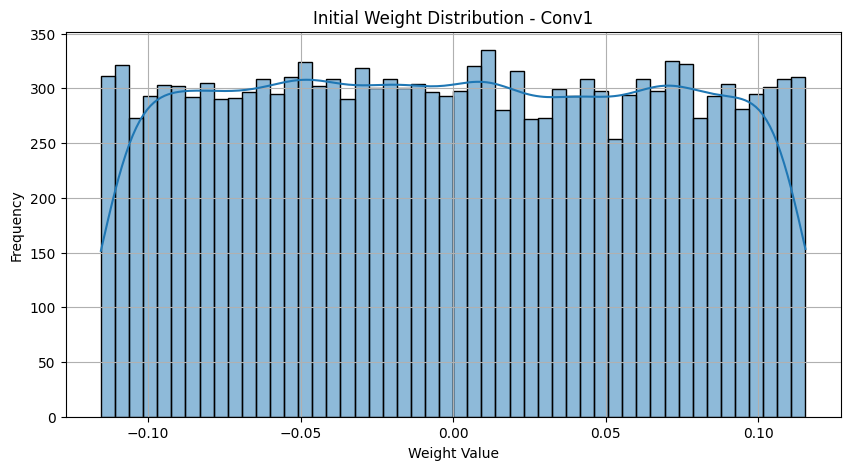

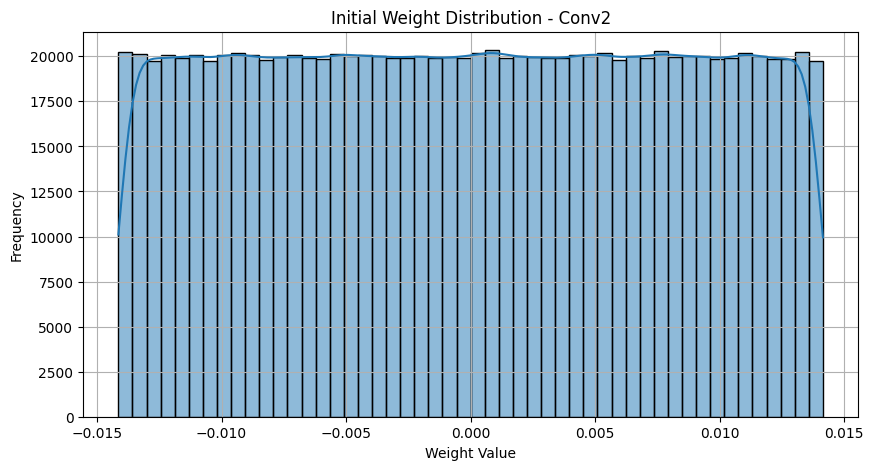

Files already downloaded and verified
Analysis after epoch 1


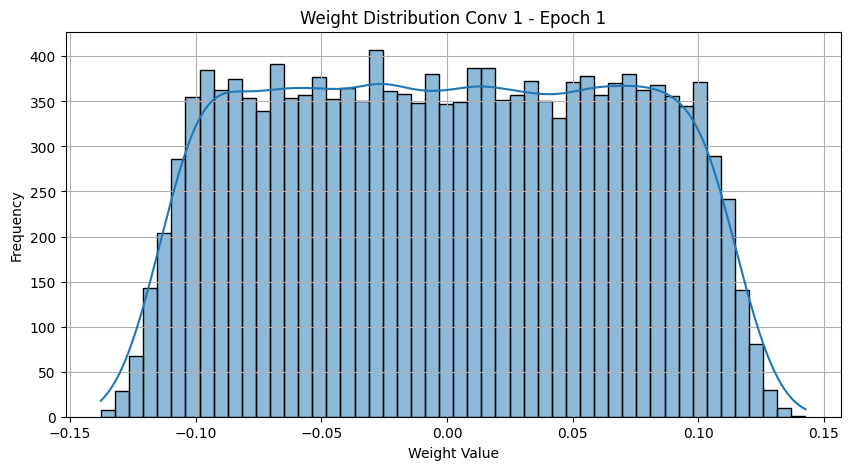

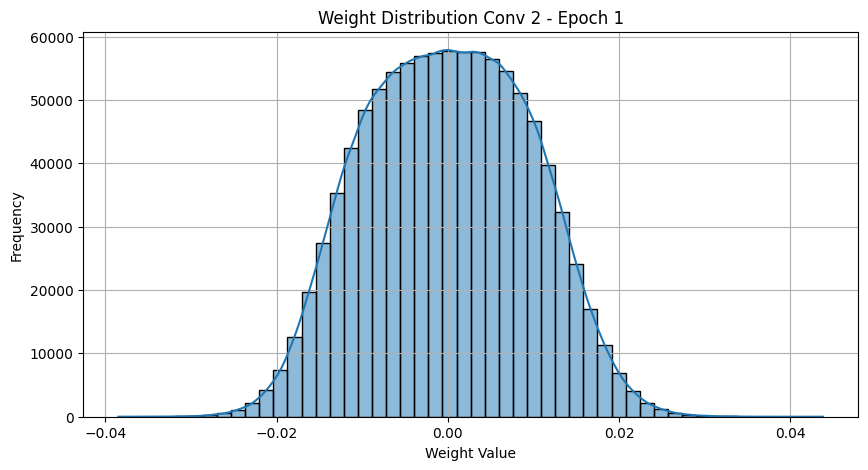

Statistics of the weights for conv1:
Mean: -2.2889487809152342e-05
Standard Deviation: 0.06729879230260849
Minimum: -0.13778746128082275
Maximum: 0.14262790977954865
Statistics of the weights for conv2:
Mean: -6.74468128636363e-06
Standard Deviation: 0.009565182030200958
Minimum: -0.03848015144467354
Maximum: 0.043799400329589844


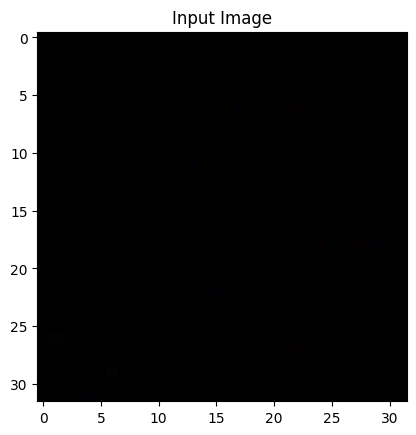

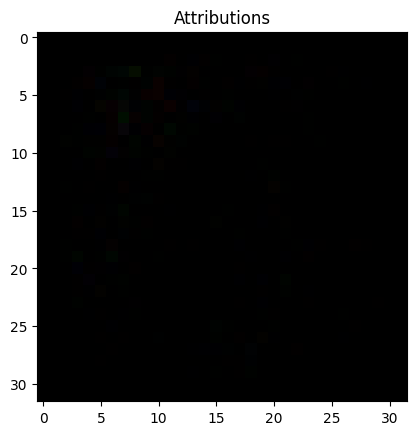

Convergence Delta: tensor([-0.0010], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.8275418281555176
Variance: 0.12955625355243683
Skewness: 0.419581256792021
Kurtosis: 0.3012590469214058
Sparsity: 0.004624920280612245


Analysis for layer: conv2
Mean: 0.7928355932235718
Variance: 0.5201644897460938
Skewness: 0.6917005580349617
Kurtosis: -0.22568874156194818
Sparsity: 0.2603125


Files already downloaded and verified






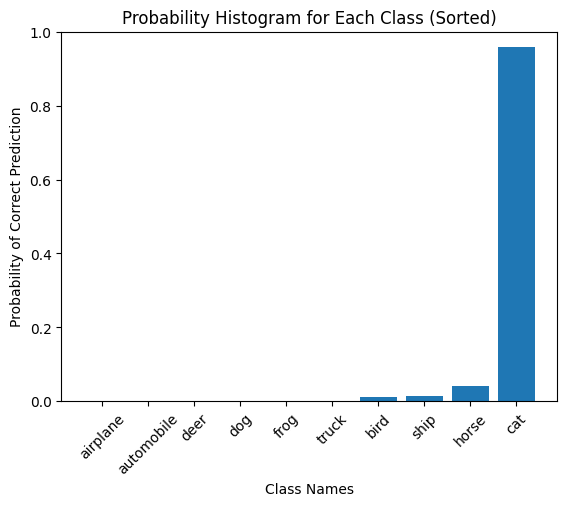



Accuracy on the test set after the final epoch: 10.25%
Analysis after epoch 5


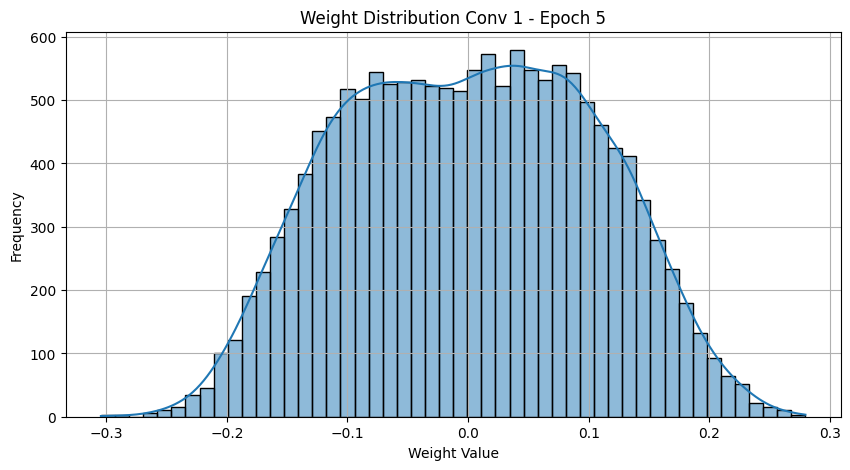

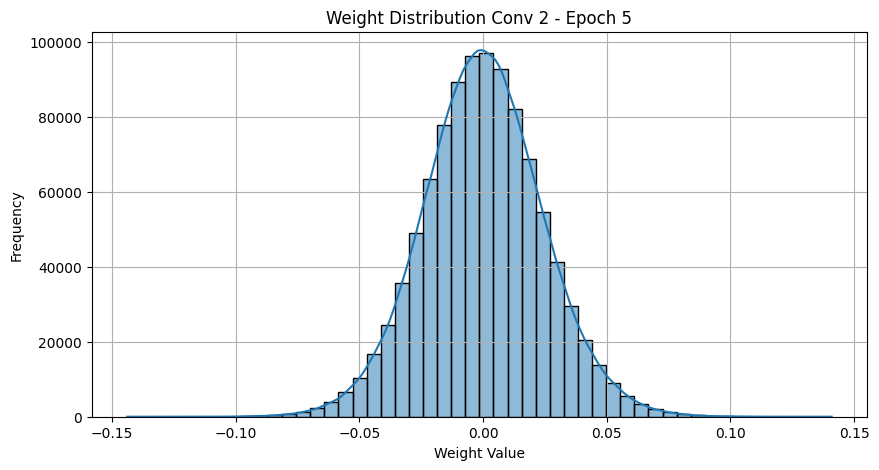

Statistics of the weights for conv1:
Mean: 0.0004586557624861598
Standard Deviation: 0.1033027246594429
Minimum: -0.3044588565826416
Maximum: 0.27975016832351685
Statistics of the weights for conv2:
Mean: -6.448522526625311e-06
Standard Deviation: 0.024172378703951836
Minimum: -0.14393340051174164
Maximum: 0.14094994962215424


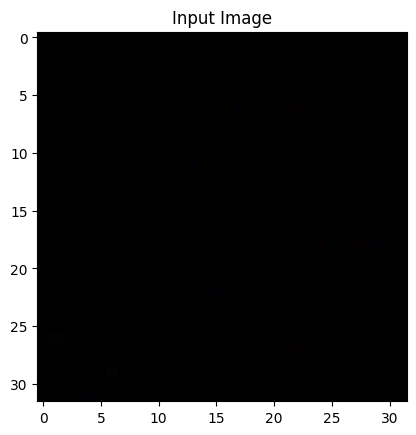

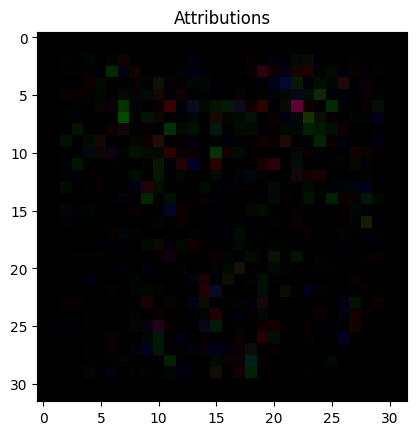

Convergence Delta: tensor([-0.0561], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 1.0409986972808838
Variance: 0.19934125244617462
Skewness: 0.4735199659772497
Kurtosis: 0.3922713819662542
Sparsity: 0.0032669005102040818


Analysis for layer: conv2
Mean: 0.9407727718353271
Variance: 0.6267414689064026
Skewness: 0.5859313546861317
Kurtosis: -0.44021708902955625
Sparsity: 0.1945184948979592


Files already downloaded and verified






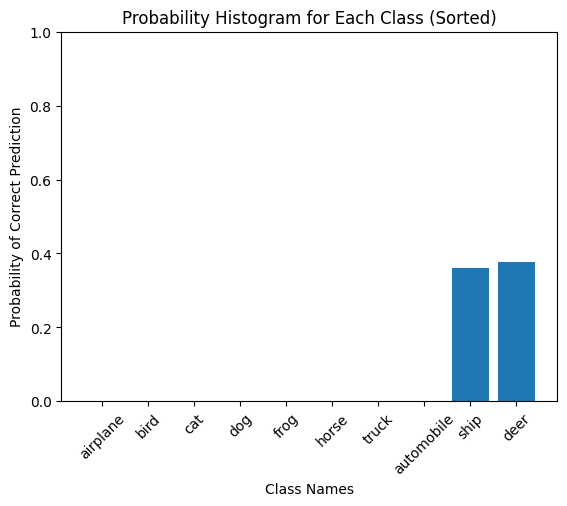



Accuracy on the test set after the final epoch: 7.40%
Analysis after epoch 10


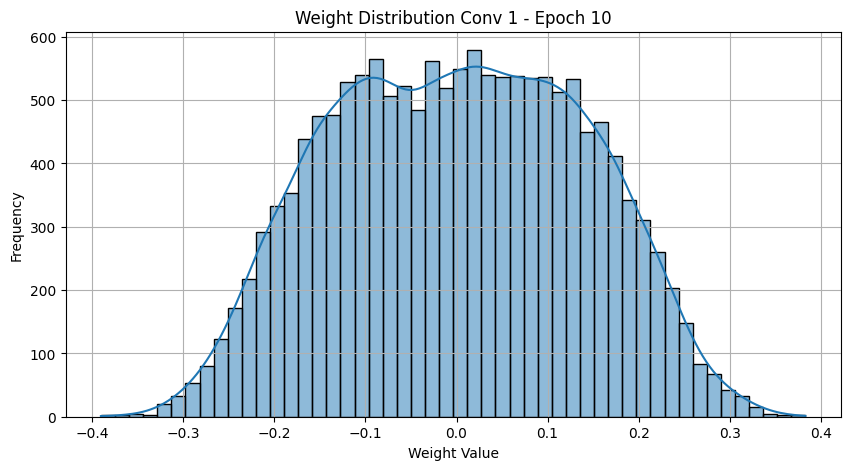

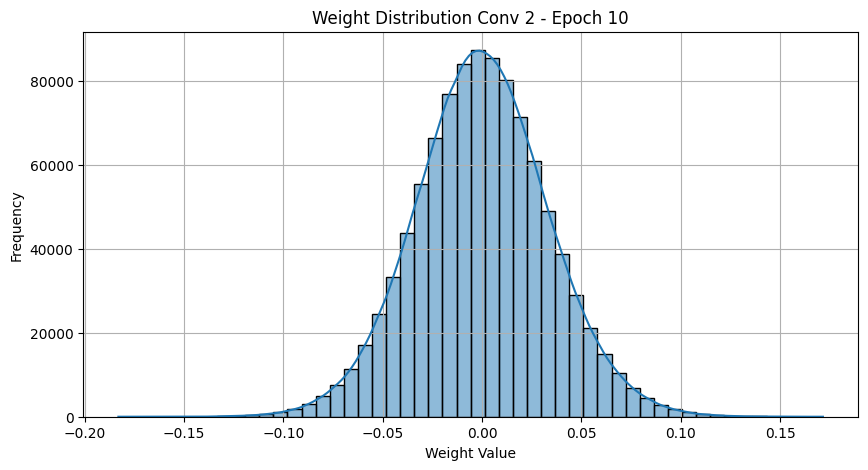

Statistics of the weights for conv1:
Mean: 0.0006319144158624113
Standard Deviation: 0.13686658442020416
Minimum: -0.390567421913147
Maximum: 0.38309410214424133
Statistics of the weights for conv2:
Mean: -3.8119484088383615e-05
Standard Deviation: 0.03359583392739296
Minimum: -0.1830245852470398
Maximum: 0.1715618371963501


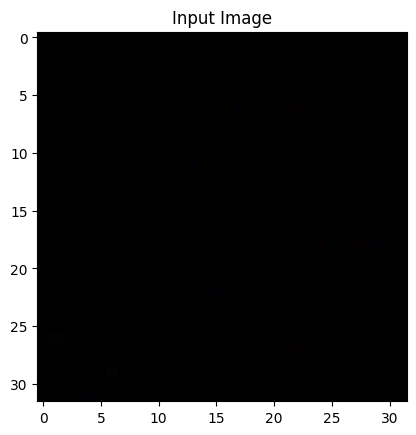

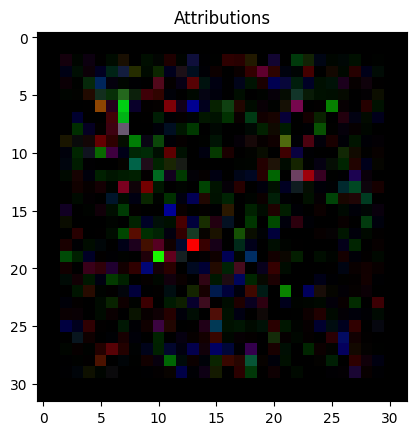

Convergence Delta: tensor([0.1925], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 1.119825005531311
Variance: 0.24655036628246307
Skewness: 0.4878107195746801
Kurtosis: 0.4031784168844701
Sparsity: 0.004233896683673469


Analysis for layer: conv2
Mean: 1.0061596632003784
Variance: 0.6056300401687622
Skewness: 0.5220094033737036
Kurtosis: -0.3898037886985546
Sparsity: 0.14759566326530613


Files already downloaded and verified






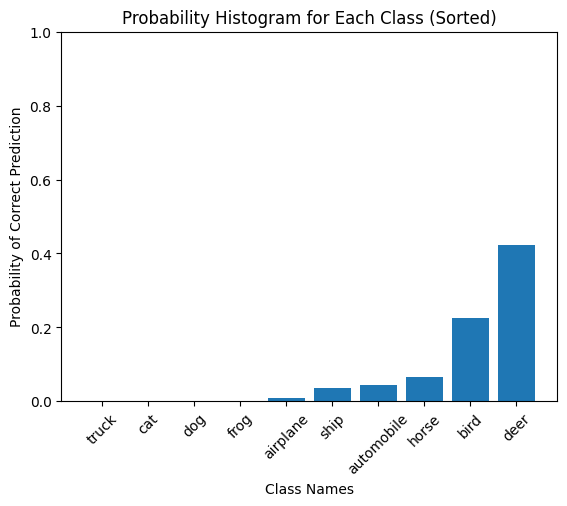



Accuracy on the test set after the final epoch: 8.05%
Analysis after epoch 15


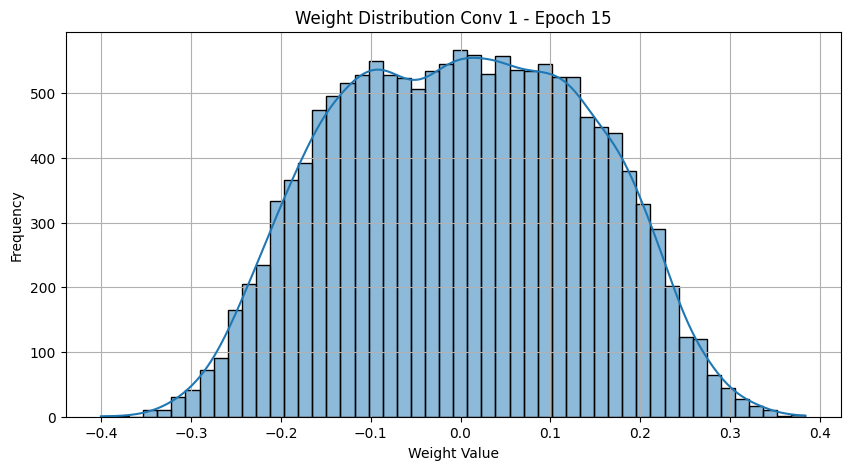

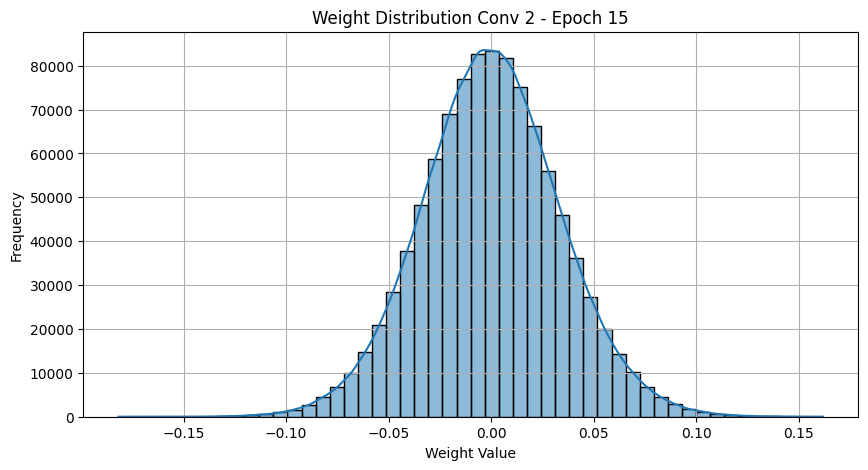

Statistics of the weights for conv1:
Mean: 0.00042896755621768534
Standard Deviation: 0.13784106075763702
Minimum: -0.4006430208683014
Maximum: 0.3842146694660187
Statistics of the weights for conv2:
Mean: -9.475836850469932e-05
Standard Deviation: 0.03386559709906578
Minimum: -0.18184036016464233
Maximum: 0.16172142326831818


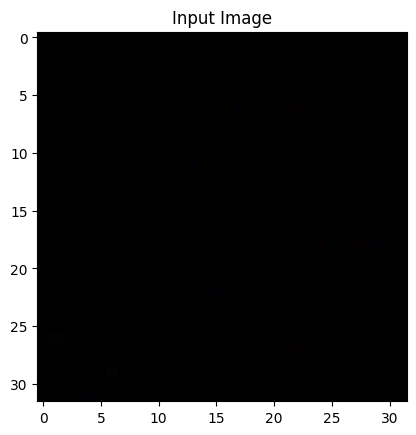

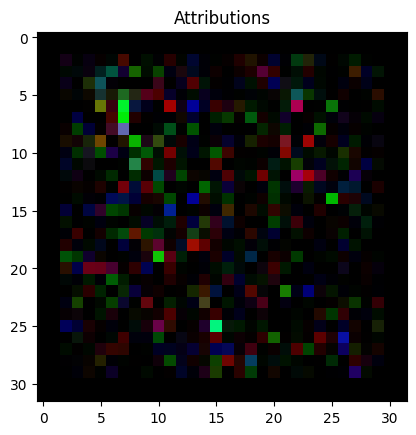

Convergence Delta: tensor([0.0276], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 1.119576334953308
Variance: 0.24725590646266937
Skewness: 0.48256842349375484
Kurtosis: 0.3885040936581614
Sparsity: 0.004307238520408163


Analysis for layer: conv2
Mean: 1.0235557556152344
Variance: 0.6116181015968323
Skewness: 0.5090251380236017
Kurtosis: -0.397725712023687
Sparsity: 0.13920599489795918


Files already downloaded and verified






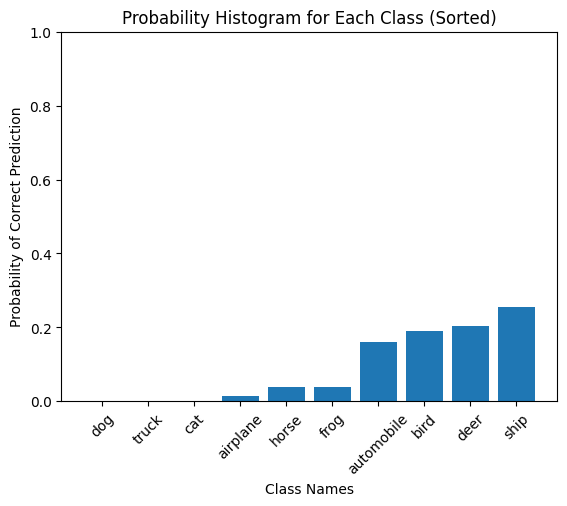



Accuracy on the test set after the final epoch: 9.06%
Analysis after epoch 20


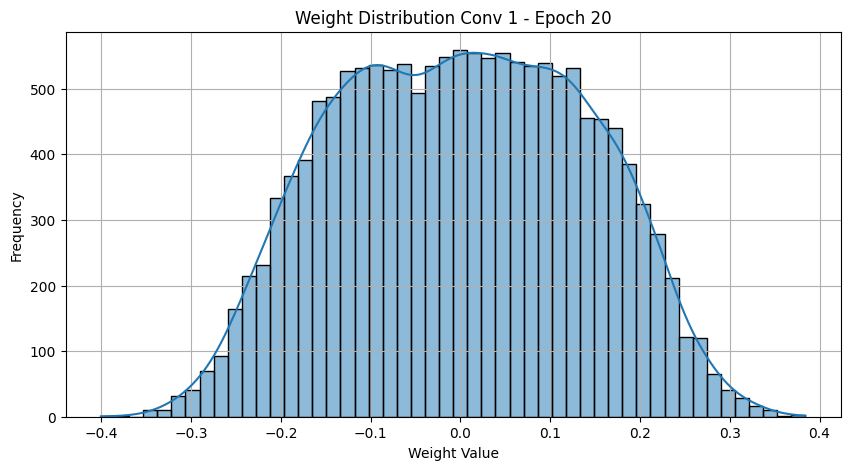

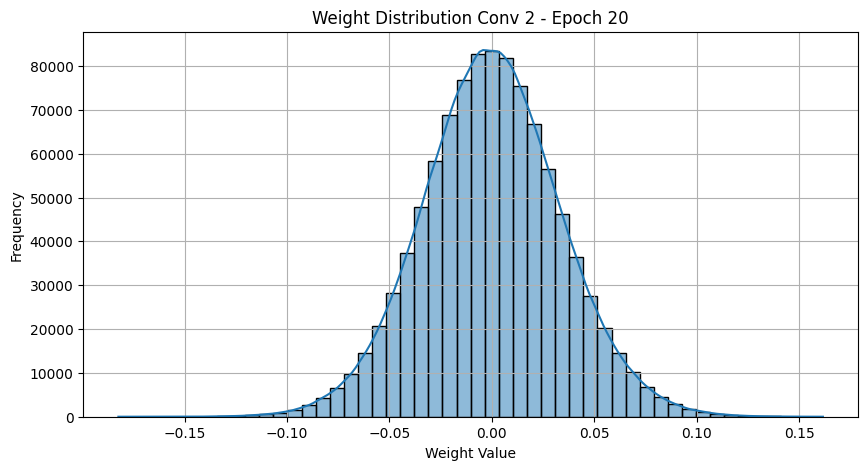

Statistics of the weights for conv1:
Mean: 0.0004504625976551324
Standard Deviation: 0.1378445327281952
Minimum: -0.40043342113494873
Maximum: 0.384305477142334
Statistics of the weights for conv2:
Mean: -9.30910391616635e-05
Standard Deviation: 0.033866625279188156
Minimum: -0.18227650225162506
Maximum: 0.16164758801460266


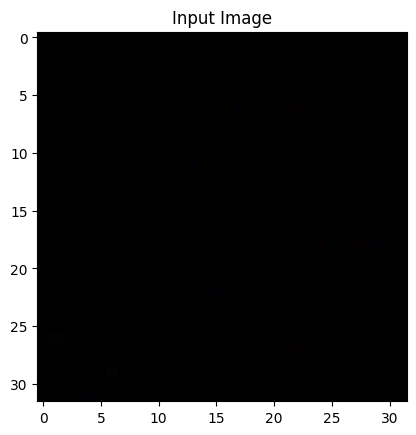

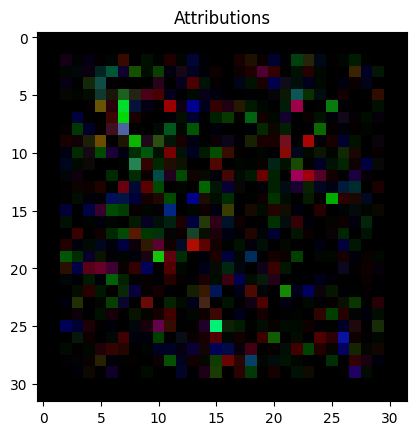

Convergence Delta: tensor([0.0751], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 1.1206742525100708
Variance: 0.24720187485218048
Skewness: 0.48655164728678896
Kurtosis: 0.39082460125400553
Sparsity: 0.00416454081632653


Analysis for layer: conv2
Mean: 1.0262963771820068
Variance: 0.6104182600975037
Skewness: 0.5026080809852674
Kurtosis: -0.4093038397266122
Sparsity: 0.13716198979591837


Files already downloaded and verified






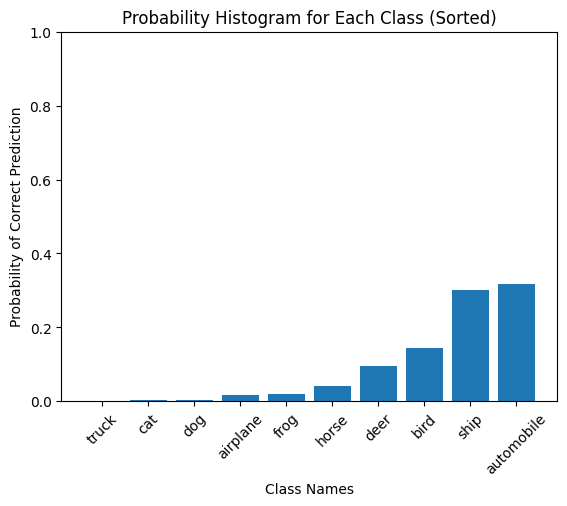



Accuracy on the test set after the final epoch: 9.42%
Analysis after epoch 25


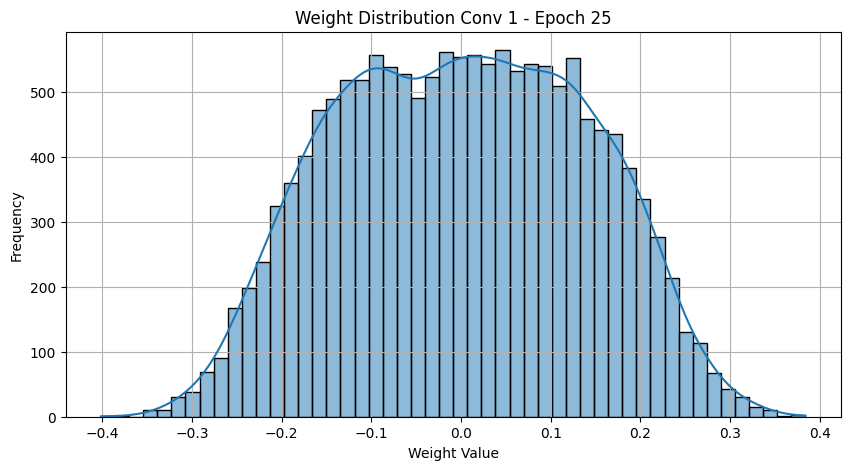

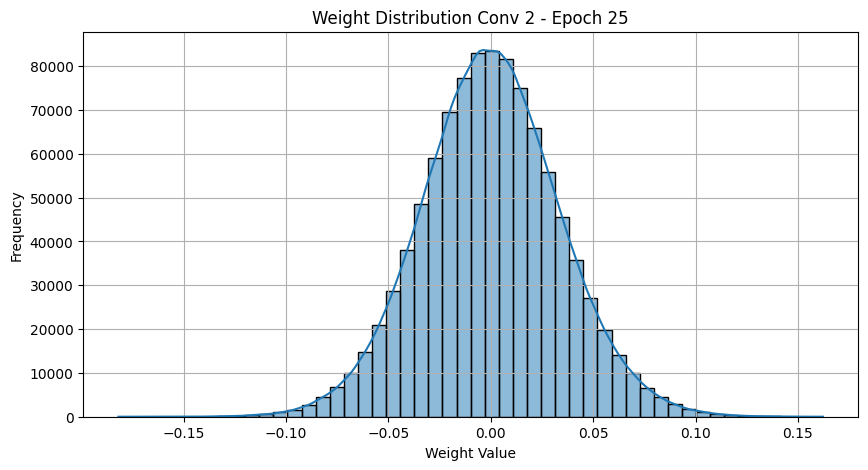

Statistics of the weights for conv1:
Mean: 0.0004677143006119877
Standard Deviation: 0.13785064220428467
Minimum: -0.4014517068862915
Maximum: 0.38400211930274963
Statistics of the weights for conv2:
Mean: -9.241305815521628e-05
Standard Deviation: 0.03386833891272545
Minimum: -0.18192605674266815
Maximum: 0.1622043251991272


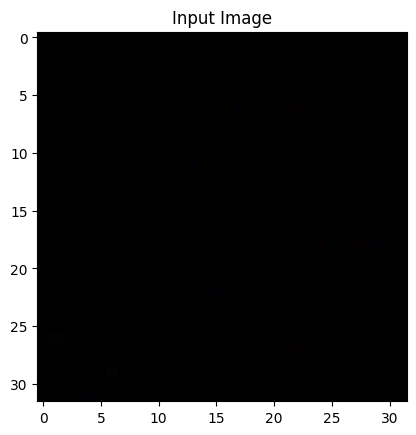

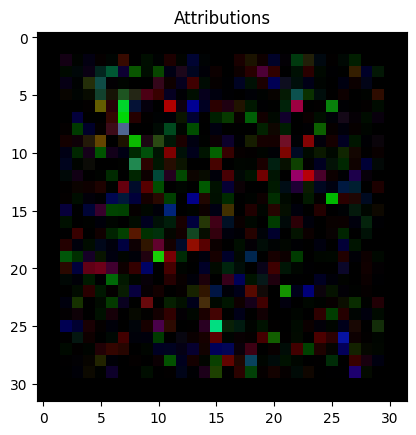

Convergence Delta: tensor([0.3463], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 1.1200264692306519
Variance: 0.24745555222034454
Skewness: 0.490890899128698
Kurtosis: 0.41435203135315035
Sparsity: 0.004259406887755102


Analysis for layer: conv2
Mean: 1.0302999019622803
Variance: 0.6106927990913391
Skewness: 0.500248858646874
Kurtosis: -0.4101560399581663
Sparsity: 0.13480070153061224


Files already downloaded and verified






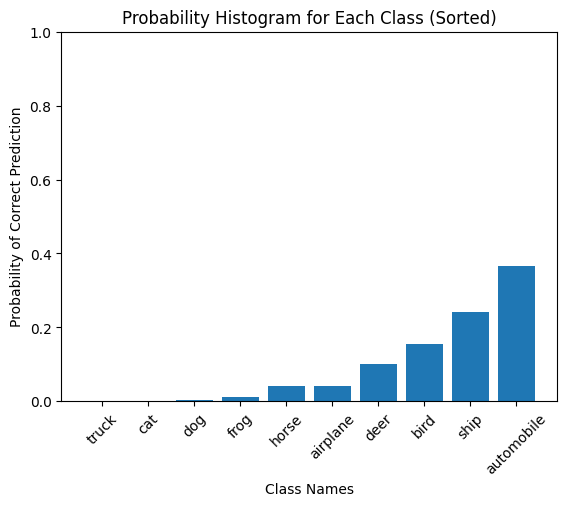



Accuracy on the test set after the final epoch: 9.64%
Analysis after epoch 30


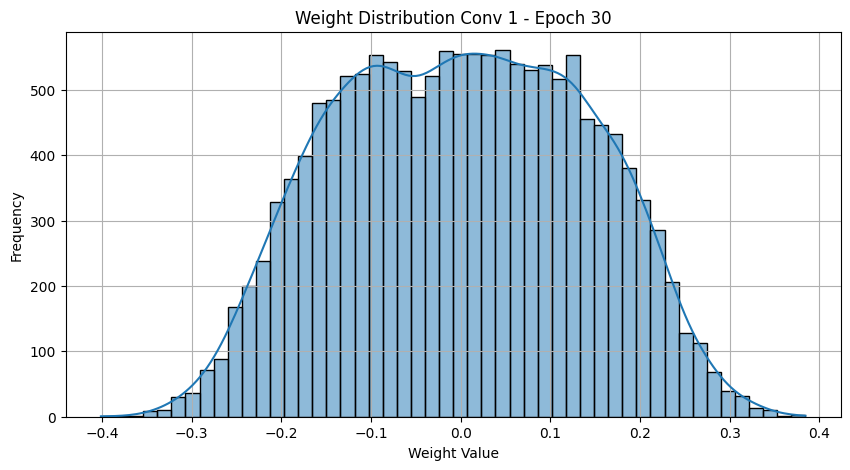

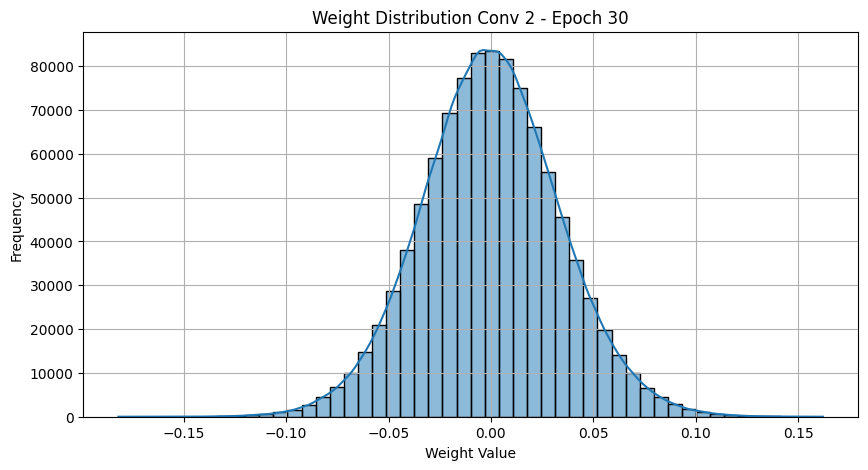

Statistics of the weights for conv1:
Mean: 0.00045940809650346637
Standard Deviation: 0.1378510743379593
Minimum: -0.40131548047065735
Maximum: 0.3845064043998718
Statistics of the weights for conv2:
Mean: -9.648070408729836e-05
Standard Deviation: 0.03386843949556351
Minimum: -0.1819574385881424
Maximum: 0.16216807067394257


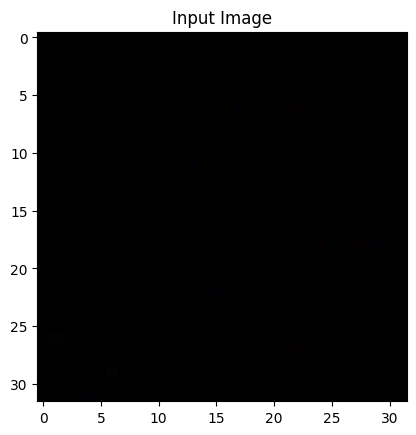

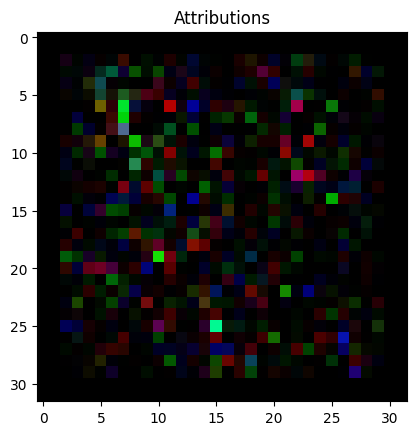

Convergence Delta: tensor([0.2165], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 1.1172609329223633
Variance: 0.24507643282413483
Skewness: 0.483017428751302
Kurtosis: 0.4011580329643847
Sparsity: 0.004273357780612245


Analysis for layer: conv2
Mean: 1.0276561975479126
Variance: 0.6055101752281189
Skewness: 0.5118181188371744
Kurtosis: -0.3732410509985664
Sparsity: 0.13280293367346938


Files already downloaded and verified






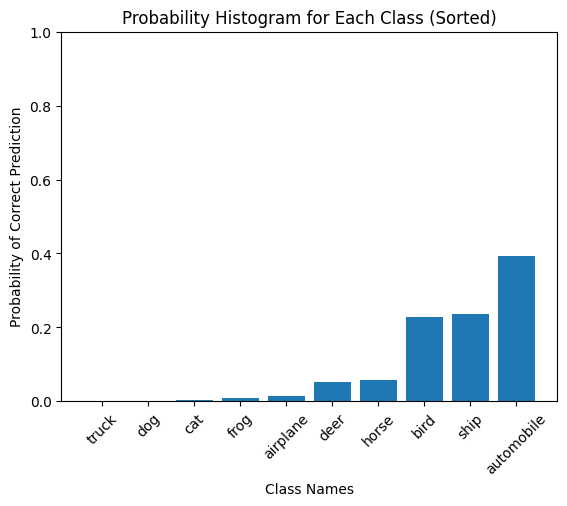



Accuracy on the test set after the final epoch: 9.92%


In [27]:
num_initializations = 1
# all_p_corrects_randx = np.zeros(len(randX_dataset))

for _ in range(num_initializations):

    sample_data, sample_target = next(iter(randX_loader))
    sample_data, sample_target = sample_data.to(device), sample_target.to(device)
    input_image = sample_data[0:1]  # Single image with batch dimension
    true_label = sample_target[0].item()

    model2 = SimpleCNNWithHooks().to(device)
    optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

    # Visualize initial weight distribution for conv1
    initial_weights_conv1 = model2.conv1.weight.data
    plot_weight_distribution(initial_weights_conv1, "Initial Weight Distribution - Conv1")
    # Visualize initial weight distribution for conv2
    initial_weights_conv2 = model2.conv2.weight.data
    plot_weight_distribution(initial_weights_conv2, "Initial Weight Distribution - Conv2")
    val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


    for epoch in range(30):
      model2.train()
      for data, target in randX_loader:
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model2(data)
          loss = nn.CrossEntropyLoss()(output, target)
          loss.backward()
          optimizer.step()

      if (epoch + 1)%10==0 or epoch==0:
        # Save activations
        model2.eval()
        activations = {}
        with torch.no_grad():
            for data, _ in randX_subset_loader:  # Consider using a subset of data if full dataset is too large
                data = data.to(device)
                _ = model2(data)
                for layer_name, activation in model2.activations.items():
                    if layer_name not in activations:
                        activations[layer_name] = []
                    activations[layer_name].append(activation.cpu().numpy())

        # Save activations to disk
        with open(f'model2_activations_epoch_{epoch+1}.pkl', 'wb') as f:
            pickle.dump(activations, f)

      if (epoch + 1) % 5 == 0 or epoch==0:  # Save every 5 epochs
       # Clear cache
        torch.cuda.empty_cache()

        # Save model weights
        #torch.save(model2.state_dict(), f'model_2_epoch_{epoch+1}.pth')

        # Analysis
        print(f"Analysis after epoch {epoch + 1}")

        # Weight distribution and statistics
        weights = model2.conv1.weight.data
        plot_weight_distribution(weights, f"Weight Distribution Conv 1 - Epoch {epoch + 1}")

        weightsConv2 = model2.conv2.weight.data
        plot_weight_distribution(weightsConv2, f"Weight Distribution Conv 2 - Epoch {epoch + 1}")

        mean = weights.mean().item()
        std = weights.std().item()
        min_val = weights.min().item()
        max_val = weights.max().item()

        print("Statistics of the weights for conv1:")
        print("Mean:", mean)
        print("Standard Deviation:", std)
        print("Minimum:", min_val)
        print("Maximum:", max_val)

        mean = weightsConv2.mean().item()
        std = weightsConv2.std().item()
        min_val = weightsConv2.min().item()
        max_val = weightsConv2.max().item()

        print("Statistics of the weights for conv2:")
        print("Mean:", mean)
        print("Standard Deviation:", std)
        print("Minimum:", min_val)
        print("Maximum:", max_val)

        # Attribution Analysis
        calculate_and_plot_attributions(model2, input_image, true_label)

        # Activation Analysis
        model2.eval()
        images, labels = next(iter(randX_loader))
        images = images.to(device)
        with torch.no_grad():
            _ = model2(images)
        for layer_name, activation in model2.activations.items():
          print(f"Analysis for layer: {layer_name}")
          mean, variance = calculate_mean_variance(activation)
          skewness, kurtosis_val = calculate_skewness_kurtosis(activation)
          sparsity = calculate_sparsity(activation)

          print(f"Mean: {mean}")
          print(f"Variance: {variance}")
          print(f"Skewness: {skewness}")
          print(f"Kurtosis: {kurtosis_val}")
          print(f"Sparsity: {sparsity}")
          print("\n")

        # Confusion Matrix
        val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
        classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        y_pred, y_true = get_predictions(model2, val_loader)
        cm = confusion_matrix(y_true, y_pred)
        # plt.figure(figsize=(10, 8))
        # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        # plt.xlabel('Predicted Labels')
        # plt.ylabel('True Labels')
        # plt.title(f'Confusion Matrix - Epoch {epoch + 1}')
        # plt.show()

        print("\n")
        print("\n")

         # Calculate the probabilities
        class_probabilities = np.diag(cm) / np.sum(cm, axis=1)

        # Sorting the probabilities along with the class names
        sorted_indices = np.argsort(class_probabilities)
        sorted_classes = np.array(classes)[sorted_indices]
        sorted_probabilities = np.array(class_probabilities)[sorted_indices]
        # Plotting the histogram in sorted order
        plt.bar(sorted_classes, sorted_probabilities)
        plt.xlabel('Class Names')
        plt.ylabel('Probability of Correct Prediction')
        plt.title('Probability Histogram for Each Class (Sorted)')
        plt.ylim(0, 1)  # Set y-axis limit to [0, 1] as probabilities range between 0 and 1
        plt.xticks(rotation=45)  # Rotate class names for better readability
        plt.show()
        accuracy = calculate_accuracy(model2, val_loader)
        print("\n")
        print(f'Accuracy on the test set after the final epoch: {accuracy * 100:.2f}%')
      scheduler.step()

##Random labels

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [29]:
formatted_data_tensor = torch.tensor(np.transpose(train_dataset.data, (0, 3, 1, 2)), dtype=torch.float) / 255.

randY_labels = torch.tensor(np.random.randint(0, 10, len(train_dataset)), dtype=torch.long)

randY_dataset = torch.utils.data.TensorDataset(formatted_data_tensor, randY_labels)
randY_loader = torch.utils.data.DataLoader(randY_dataset, batch_size=64, shuffle=True)

In [30]:
# Subset for random labels
randY_data_subset = formatted_data_tensor[subset_indices]
randY_labels_subset = torch.tensor(np.random.randint(0, 10, subset_size), dtype=torch.long)
randY_subset = torch.utils.data.TensorDataset(randY_data_subset, randY_labels_subset)
randY_subset_loader = torch.utils.data.DataLoader(randY_subset, batch_size=64, shuffle=True)


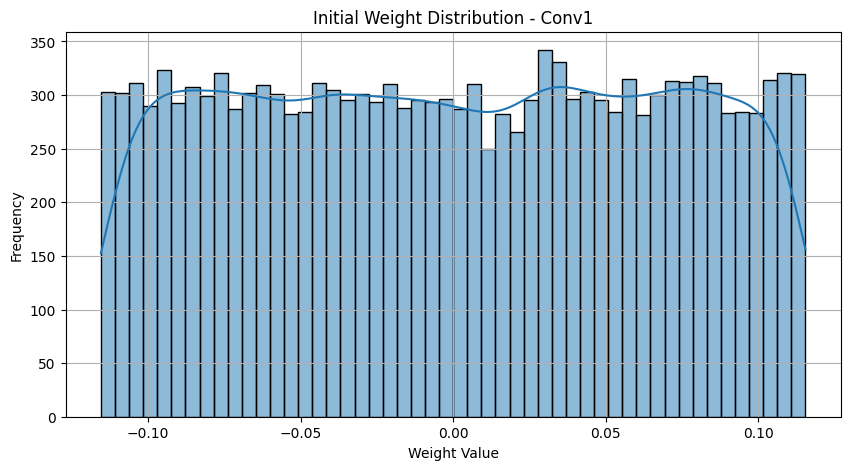

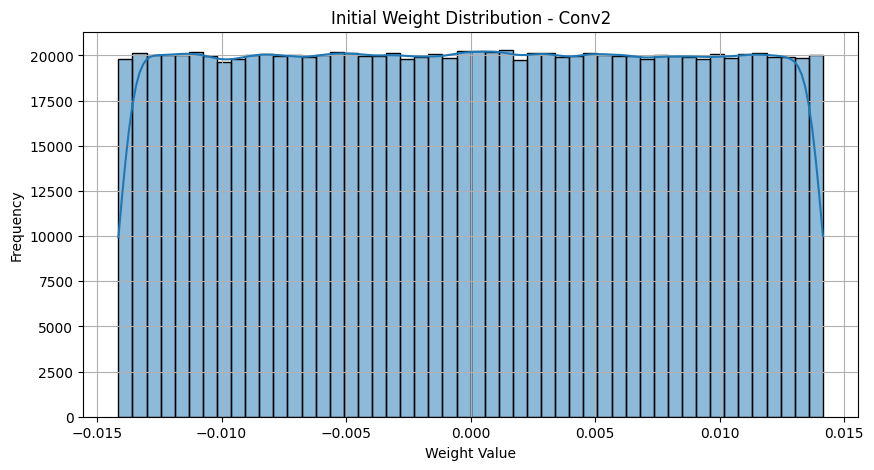

Files already downloaded and verified
Analysis after epoch 1


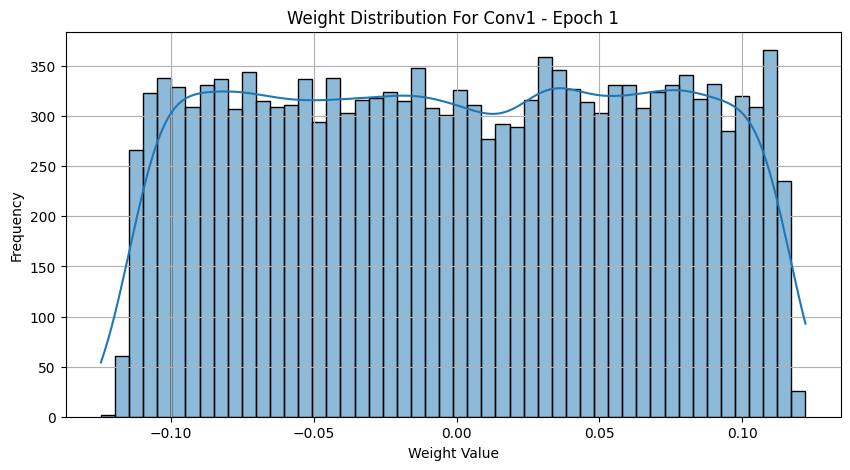

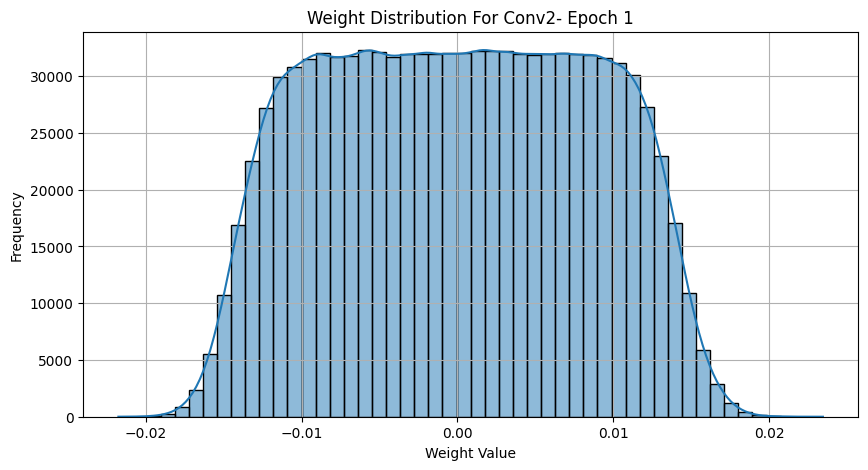

Statistics of the weights for conv1:
Mean: 0.0007730131037533283
Standard Deviation: 0.06711909919977188
Minimum: -0.12454602122306824
Maximum: 0.12211281061172485
Statistics of the weights for conv2:
Mean: -1.5728561265859753e-05
Standard Deviation: 0.008367214351892471
Minimum: -0.021751929074525833
Maximum: 0.023444095626473427


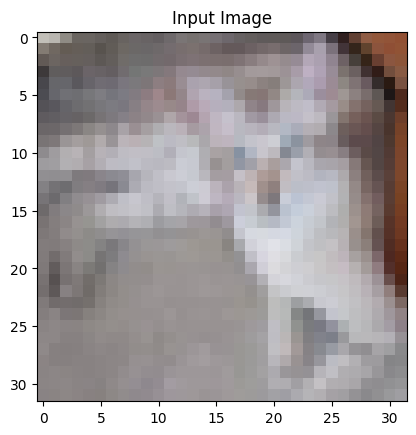

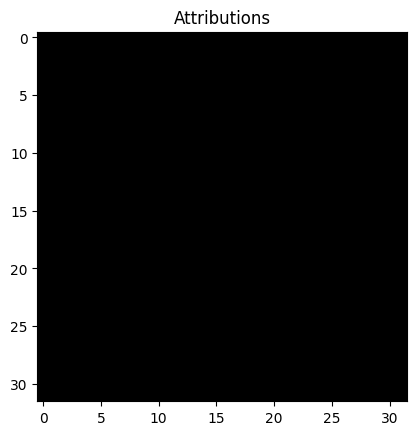

Convergence Delta: tensor([-0.0044], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.7865520715713501
Variance: 0.6382457613945007
Skewness: 1.0884706506859811
Kurtosis: 1.3165848863753986
Sparsity: 0.2708254942602041


Analysis for layer: conv2
Mean: 0.807899534702301
Variance: 0.7122487425804138
Skewness: 1.153996724702734
Kurtosis: 1.211962182877449
Sparsity: 0.2825908801020408


Files already downloaded and verified






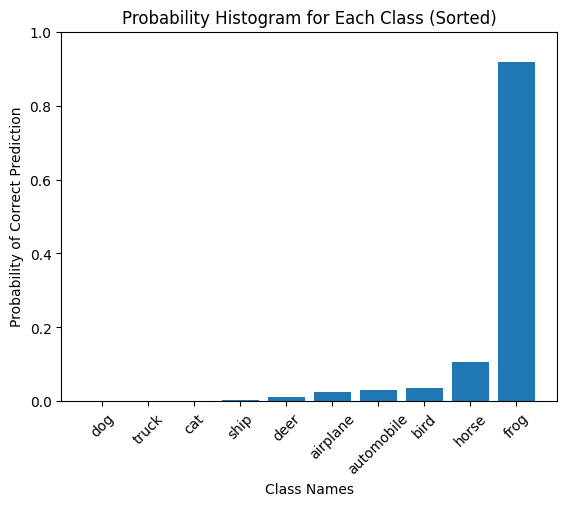



Accuracy on the test set after the final epoch: 11.31%
Analysis after epoch 5


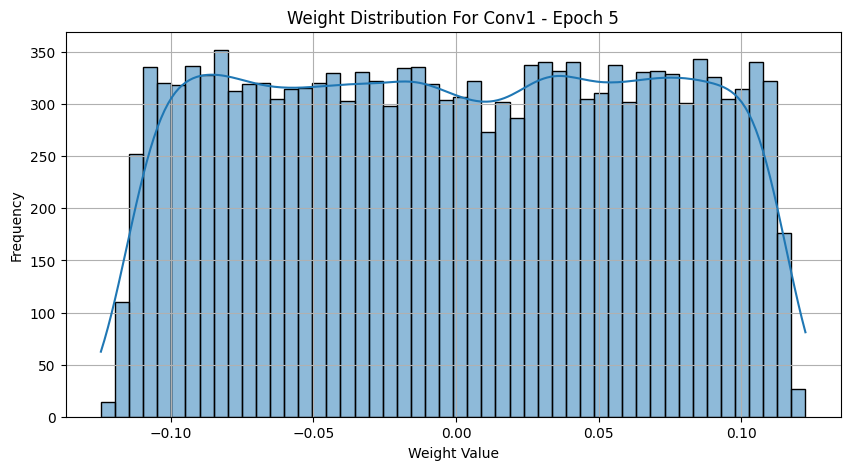

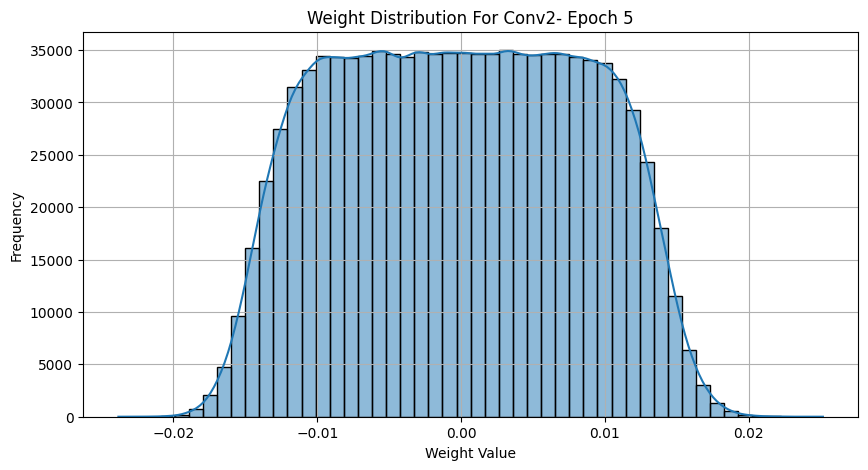

Statistics of the weights for conv1:
Mean: 4.897264079772867e-05
Standard Deviation: 0.06716201454401016
Minimum: -0.12450482696294785
Maximum: 0.1225254088640213
Statistics of the weights for conv2:
Mean: -0.0001250737113878131
Standard Deviation: 0.00842676218599081
Minimum: -0.023831825703382492
Maximum: 0.02517067641019821


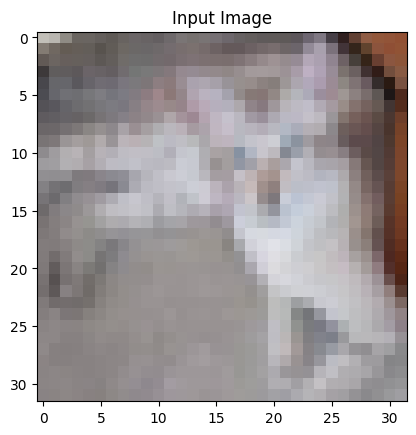

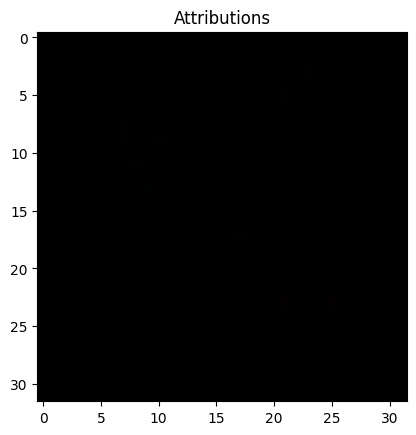

Convergence Delta: tensor([-0.0027], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.743765652179718
Variance: 0.5792003870010376
Skewness: 1.23966702319852
Kurtosis: 1.9957215670700332
Sparsity: 0.24874880420918366


Analysis for layer: conv2
Mean: 0.8302465677261353
Variance: 0.5983334183692932
Skewness: 0.9438295079139583
Kurtosis: 0.8355963023607247
Sparsity: 0.22784598214285715


Files already downloaded and verified






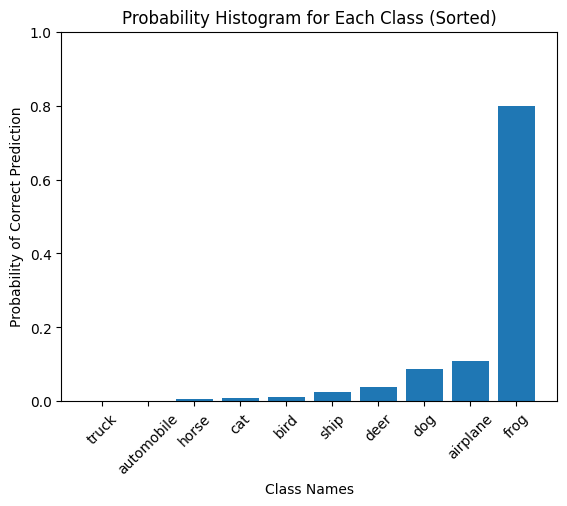



Accuracy on the test set after the final epoch: 10.91%
Analysis after epoch 10


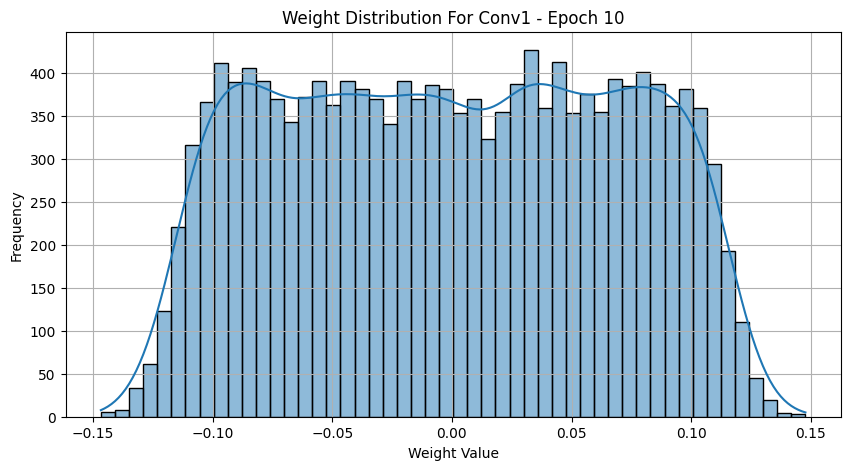

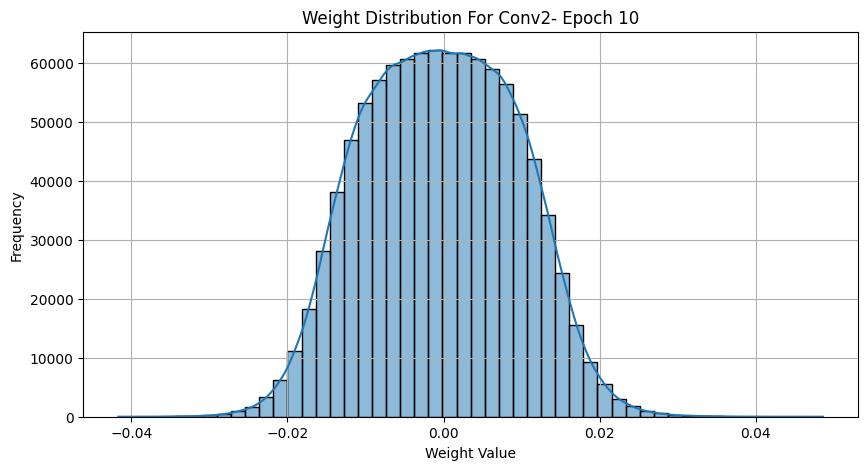

Statistics of the weights for conv1:
Mean: -0.0004983513499610126
Standard Deviation: 0.0684865415096283
Minimum: -0.14670367538928986
Maximum: 0.14775685966014862
Statistics of the weights for conv2:
Mean: -0.00039905114681459963
Standard Deviation: 0.009717565029859543
Minimum: -0.04165026545524597
Maximum: 0.04859239235520363


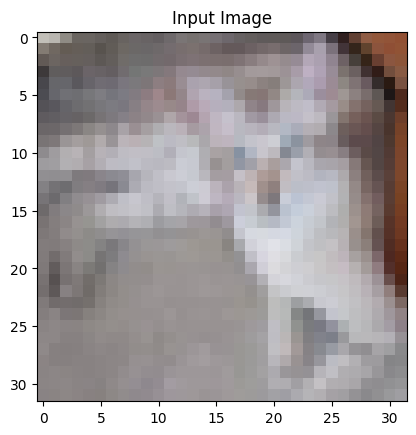

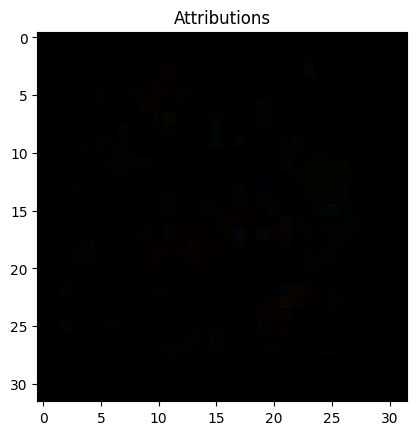

Convergence Delta: tensor([0.0137], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.8108757734298706
Variance: 0.5956628322601318
Skewness: 1.1616965302455708
Kurtosis: 1.7917937273627036
Sparsity: 0.2090836256377551


Analysis for layer: conv2
Mean: 0.9016047716140747
Variance: 0.5670586228370667
Skewness: 0.8007681252516837
Kurtosis: 0.6742012287229029
Sparsity: 0.17219866071428572


Files already downloaded and verified






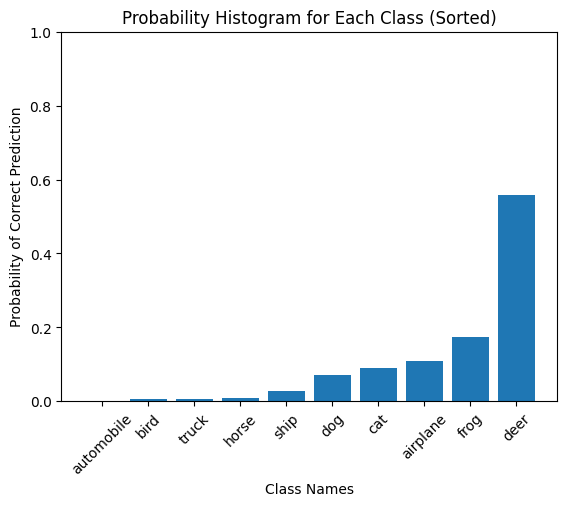



Accuracy on the test set after the final epoch: 10.51%
Analysis after epoch 15


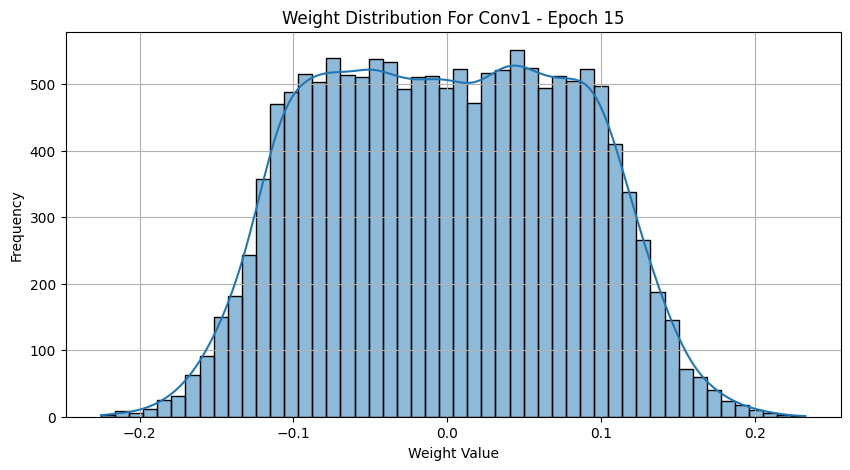

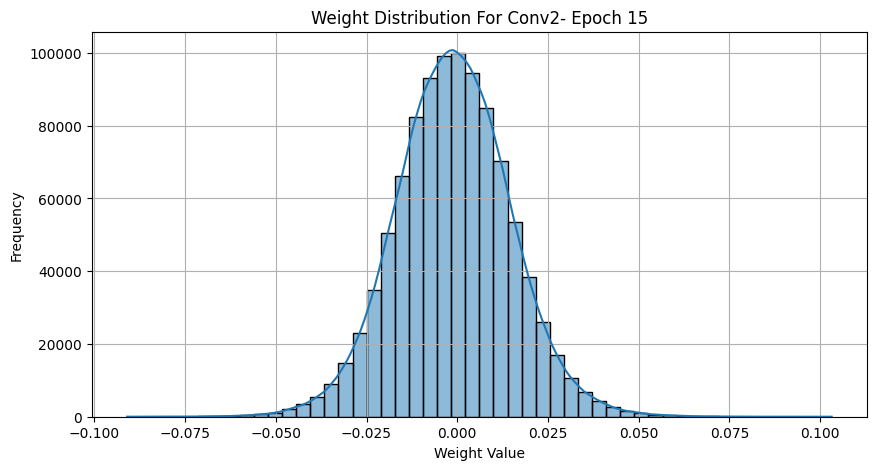

Statistics of the weights for conv1:
Mean: -0.0011931738117709756
Standard Deviation: 0.08129479736089706
Minimum: -0.22525233030319214
Maximum: 0.23291058838367462
Statistics of the weights for conv2:
Mean: -0.0010549630969762802
Standard Deviation: 0.015816155821084976
Minimum: -0.09097519516944885
Maximum: 0.10318826138973236


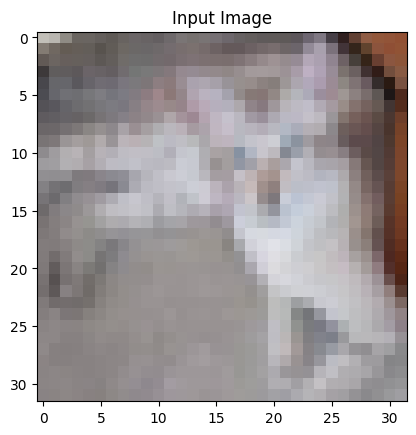

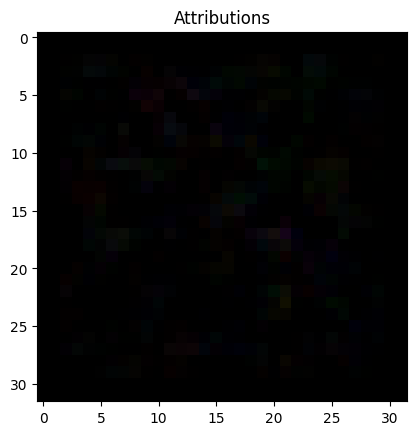

Convergence Delta: tensor([-0.1471], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.736628532409668
Variance: 0.5813992619514465
Skewness: 1.3578354693206192
Kurtosis: 2.48759525407059
Sparsity: 0.2398712531887755


Analysis for layer: conv2
Mean: 0.8782869577407837
Variance: 0.49791982769966125
Skewness: 0.7729694677325357
Kurtosis: 0.7176141710823436
Sparsity: 0.15266741071428572


Files already downloaded and verified






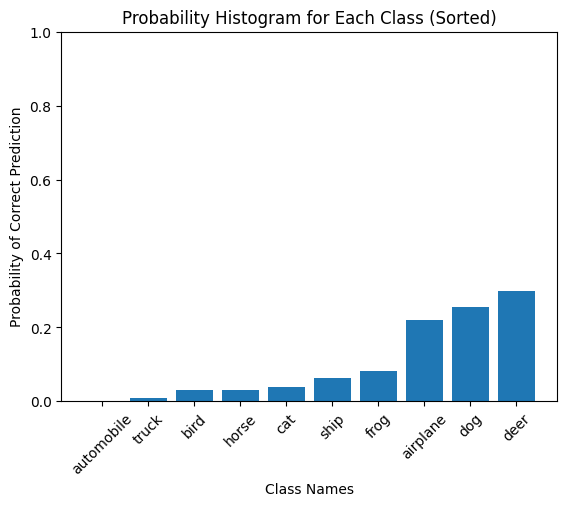



Accuracy on the test set after the final epoch: 10.26%
Analysis after epoch 20


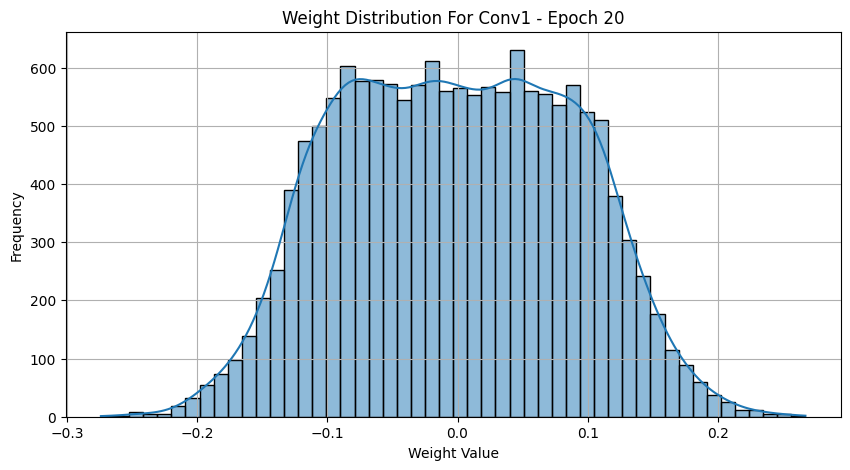

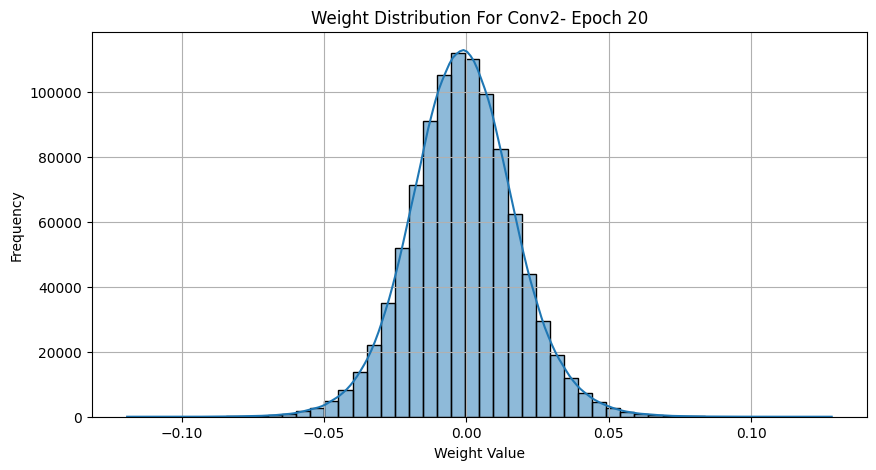

Statistics of the weights for conv1:
Mean: -0.0011621388839557767
Standard Deviation: 0.08865497261285782
Minimum: -0.27400335669517517
Maximum: 0.2672780752182007
Statistics of the weights for conv2:
Mean: -0.0012525696074590087
Standard Deviation: 0.018522843718528748
Minimum: -0.11918850988149643
Maximum: 0.12828323245048523


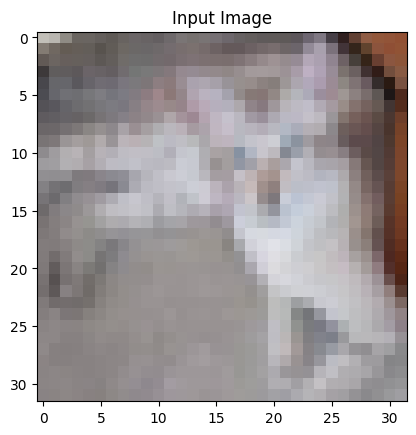

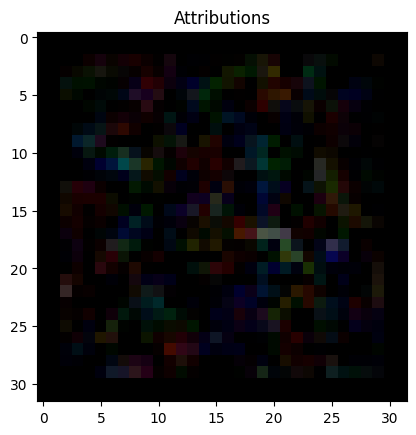

Convergence Delta: tensor([0.2290], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.7128385305404663
Variance: 0.549980640411377
Skewness: 1.406639017622729
Kurtosis: 2.7374839649109246
Sparsity: 0.2367478475765306


Analysis for layer: conv2
Mean: 0.8407399654388428
Variance: 0.4452904760837555
Skewness: 0.7459899368019391
Kurtosis: 0.6475373803644264
Sparsity: 0.14841039540816325


Files already downloaded and verified






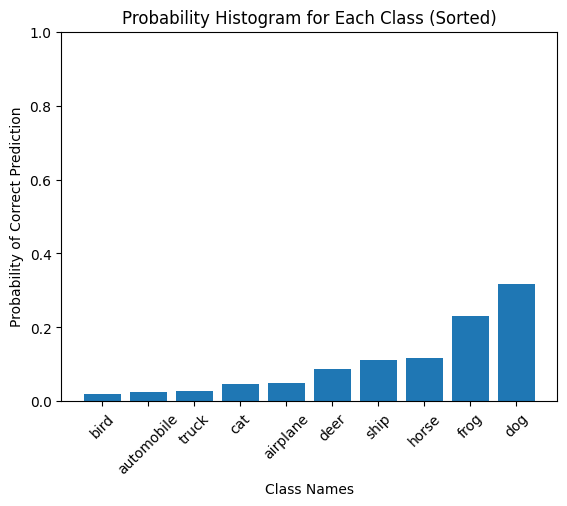



Accuracy on the test set after the final epoch: 10.36%
Analysis after epoch 25


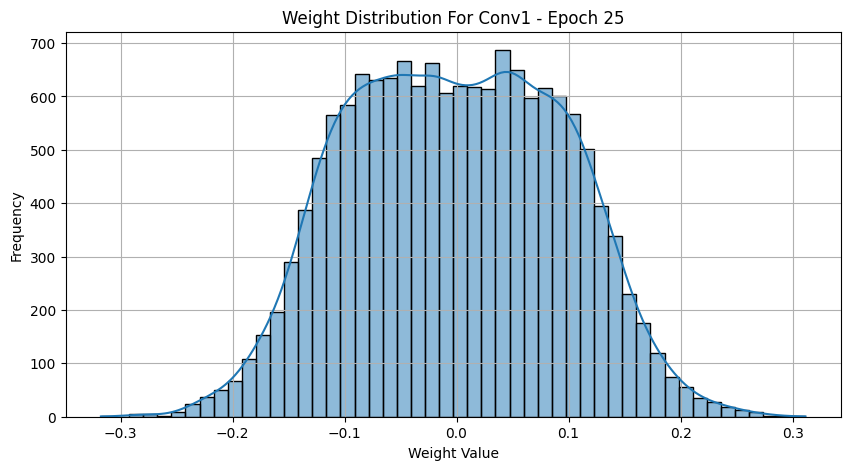

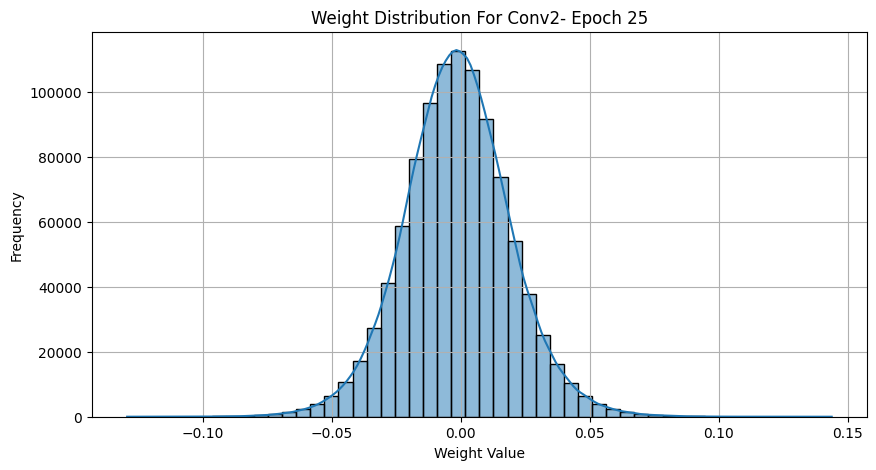

Statistics of the weights for conv1:
Mean: -0.00113373389467597
Standard Deviation: 0.09498429298400879
Minimum: -0.3175361156463623
Maximum: 0.311467707157135
Statistics of the weights for conv2:
Mean: -0.0013947170227766037
Standard Deviation: 0.02074332907795906
Minimum: -0.12933772802352905
Maximum: 0.14381060004234314


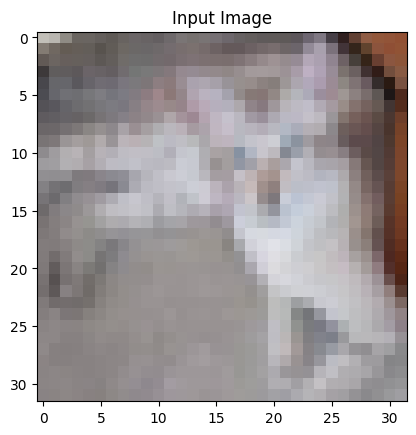

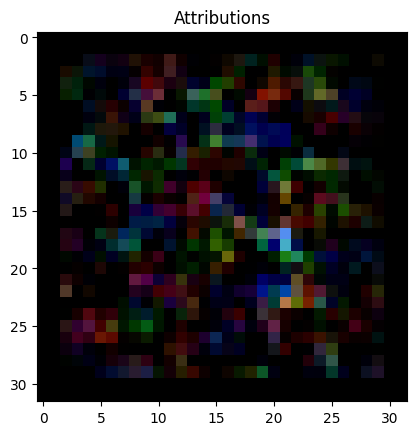

Convergence Delta: tensor([-0.1033], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.748335063457489
Variance: 0.5943673849105835
Skewness: 1.4164762501463688
Kurtosis: 2.794548777794086
Sparsity: 0.22773756377551022


Analysis for layer: conv2
Mean: 0.7983983159065247
Variance: 0.4357728362083435
Skewness: 0.8322487119692047
Kurtosis: 0.861024367214243
Sparsity: 0.16364158163265305


Files already downloaded and verified






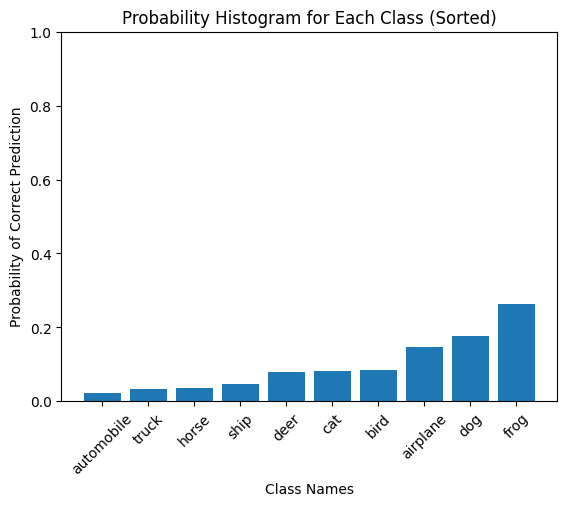



Accuracy on the test set after the final epoch: 9.70%
Analysis after epoch 30


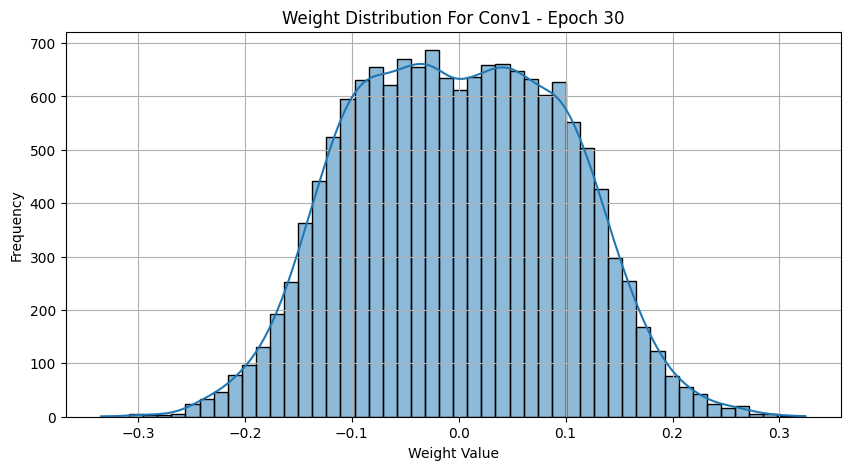

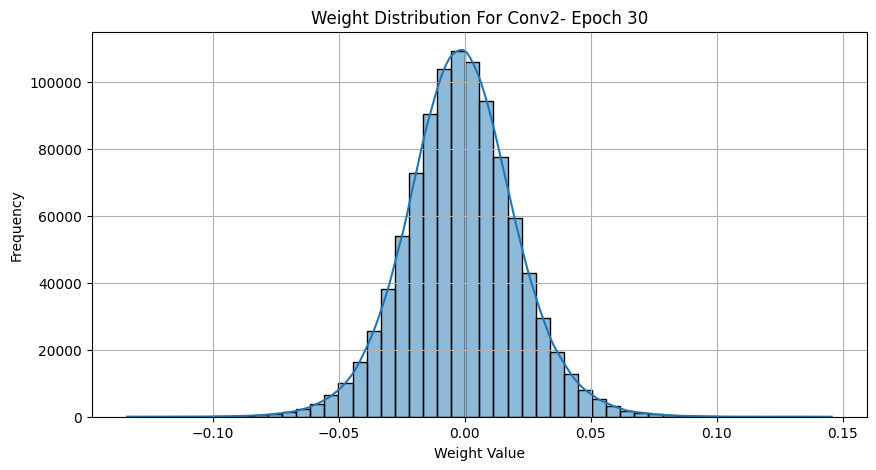

Statistics of the weights for conv1:
Mean: -0.0012045291950926185
Standard Deviation: 0.09857691824436188
Minimum: -0.3346572816371918
Maximum: 0.3242761492729187
Statistics of the weights for conv2:
Mean: -0.0014928203308954835
Standard Deviation: 0.02197413332760334
Minimum: -0.13397295773029327
Maximum: 0.14559146761894226


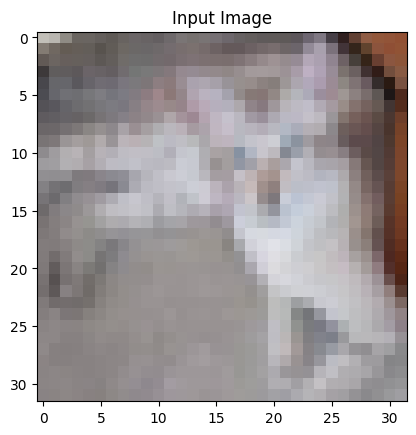

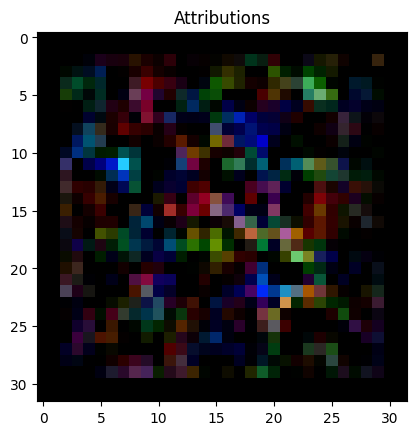

Convergence Delta: tensor([-0.2483], device='cuda:0', dtype=torch.float64)
Analysis for layer: conv1
Mean: 0.6954134106636047
Variance: 0.5125646591186523
Skewness: 1.3749693126782496
Kurtosis: 2.600825198578237
Sparsity: 0.23148955676020408


Analysis for layer: conv2
Mean: 0.7509362101554871
Variance: 0.3846409022808075
Skewness: 0.7586303533726221
Kurtosis: 0.5204881304107456
Sparsity: 0.16907684948979593


Files already downloaded and verified






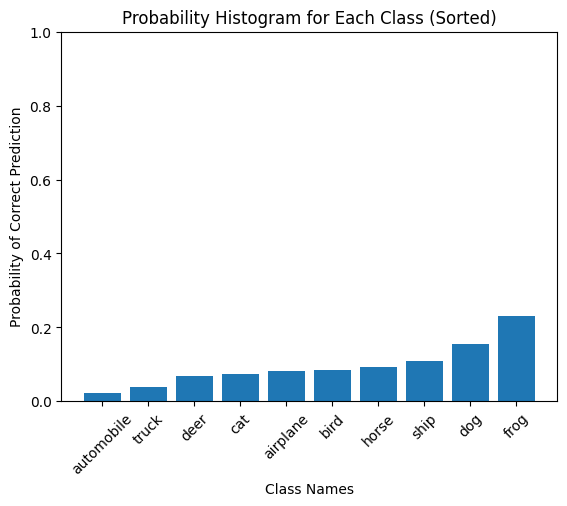



Accuracy on the test set after the final epoch: 9.65%


In [31]:
num_initializations = 1

for _ in range(num_initializations):
    sample_data, sample_target = next(iter(randY_loader))
    sample_data, sample_target = sample_data.to(device), sample_target.to(device)
    input_image = sample_data[0:1]  # Single image with batch dimension
    true_label = sample_target[0].item()

    model3 = SimpleCNNWithHooks().to(device)
    optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)


    # Visualize initial weight distribution for conv1
    initial_weights_conv1 = model3.conv1.weight.data
    plot_weight_distribution(initial_weights_conv1, "Initial Weight Distribution - Conv1")
    # Visualize initial weight distribution for conv2
    initial_weights_conv2 = model3.conv2.weight.data
    plot_weight_distribution(initial_weights_conv2, "Initial Weight Distribution - Conv2")
    val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

    for epoch in range(30):
      model3.train()
      for data, target in randY_loader:
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model3(data)
          loss = nn.CrossEntropyLoss()(output, target)
          loss.backward()
          optimizer.step()

      if (epoch + 1) % 10 == 0 or epoch==0:
        # Save activations
        model3.eval()
        activations = {}
        with torch.no_grad():
            for data, _ in randY_subset_loader:  # Consider using a subset of data if full dataset is too large
                data = data.to(device)
                _ = model3(data)
                for layer_name, activation in model3.activations.items():
                    if layer_name not in activations:
                        activations[layer_name] = []
                    activations[layer_name].append(activation.cpu().numpy())

        # Save activations to disk
        with open(f'activations_epoch_{epoch+1}.pkl', 'wb') as f:
            pickle.dump(activations, f)

      if (epoch + 1) % 5 == 0 or epoch==0:  # Save every 5 epochs
       # Clear cache
        torch.cuda.empty_cache()

        # Save model weights
        # torch.save(model3.state_dict(), f'model_epoch_{epoch+1}.pth')

        # # Save activations
        # model1.eval()
        # activations = {}
        # with torch.no_grad():
        #     for data, _ in train_loader:  # Consider using a subset of data if full dataset is too large
        #         data = data.to(device)
        #         _ = model1(data)
        #         for layer_name, activation in model1.activations.items():
        #             if layer_name not in activations:
        #                 activations[layer_name] = []
        #             activations[layer_name].append(activation.cpu().numpy())

        # # Save activations to disk
        # with open(f'activations_epoch_{epoch+1}.pkl', 'wb') as f:
        #     pickle.dump(activations, f)

        # Analysis
        print(f"Analysis after epoch {epoch + 1}")

        # Weight distribution and statistics
        weights = model3.conv1.weight.data
        plot_weight_distribution(weights, f"Weight Distribution For Conv1 - Epoch {epoch + 1}")

        weightsConv2 = model3.conv2.weight.data
        plot_weight_distribution(weightsConv2, f"Weight Distribution For Conv2- Epoch {epoch + 1}")

        mean = weights.mean().item()
        std = weights.std().item()
        min_val = weights.min().item()
        max_val = weights.max().item()

        print("Statistics of the weights for conv1:")
        print("Mean:", mean)
        print("Standard Deviation:", std)
        print("Minimum:", min_val)
        print("Maximum:", max_val)

        mean = weightsConv2.mean().item()
        std = weightsConv2.std().item()
        min_val = weightsConv2.min().item()
        max_val = weightsConv2.max().item()

        print("Statistics of the weights for conv2:")
        print("Mean:", mean)
        print("Standard Deviation:", std)
        print("Minimum:", min_val)
        print("Maximum:", max_val)


        # Attribution Analysis
        calculate_and_plot_attributions(model3, input_image, true_label)

        # Activation Analysis
        model3.eval()
        images, labels = next(iter(randY_loader))
        images = images.to(device)
        with torch.no_grad():
            _ = model3(images)
        for layer_name, activation in model3.activations.items():
          print(f"Analysis for layer: {layer_name}")
          mean, variance = calculate_mean_variance(activation)
          skewness, kurtosis_val = calculate_skewness_kurtosis(activation)
          sparsity = calculate_sparsity(activation)

          print(f"Mean: {mean}")
          print(f"Variance: {variance}")
          print(f"Skewness: {skewness}")
          print(f"Kurtosis: {kurtosis_val}")
          print(f"Sparsity: {sparsity}")
          print("\n")

        # Confusion Matrix
        val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
        classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        y_pred, y_true = get_predictions(model3, val_loader)
        cm = confusion_matrix(y_true, y_pred)
        # plt.figure(figsize=(10, 8))
        # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        # plt.xlabel('Predicted Labels')
        # plt.ylabel('True Labels')
        # plt.title(f'Confusion Matrix - Epoch {epoch + 1}')
        # plt.show()

        print("\n")
        print("\n")

        # Calculate the probabilities
        class_probabilities = np.diag(cm) / np.sum(cm, axis=1)
        # Sorting the probabilities along with the class names
        sorted_indices = np.argsort(class_probabilities)
        sorted_classes = np.array(classes)[sorted_indices]
        sorted_probabilities = np.array(class_probabilities)[sorted_indices]
        # Plotting the histogram in sorted order
        plt.bar(sorted_classes, sorted_probabilities)
        plt.xlabel('Class Names')
        plt.ylabel('Probability of Correct Prediction')
        plt.title('Probability Histogram for Each Class (Sorted)')
        plt.ylim(0, 1)  # Set y-axis limit to [0, 1] as probabilities range between 0 and 1
        plt.xticks(rotation=45)  # Rotate class names for better readability
        plt.show()
        accuracy = calculate_accuracy(model3, val_loader)
        print("\n")
        print(f'Accuracy on the test set after the final epoch: {accuracy * 100:.2f}%')
      scheduler.step()

In [32]:
# import numpy as np
# from scipy.linalg import svd

# def centering_activations(acts):
#     return acts - np.mean(acts, axis=1, keepdims=True)

# def svd_reduction(acts, components):
#     U, S, V = svd(acts, full_matrices=False)
#     return np.dot(U[:, :components], np.diag(S[:components]))

# # def cca_similarity(acts1, acts2):
# #     U1, S1, _ = svd(acts1, full_matrices=False)
# #     U2, S2, _ = svd(acts2, full_matrices=False)
# #     D = np.dot(U1.T, U2)
# #     return np.sum(np.diag(np.dot(np.diag(S1), D).dot(np.diag(S2)))) / (min(acts1.shape[0], acts2.shape[0]))

# def cca_similarity(acts1, acts2):
#     U1, _, _ = svd(acts1, full_matrices=False)
#     U2, _, _ = svd(acts2, full_matrices=False)
#     D = np.dot(U1.T, U2)

#     # Compute singular values of D which are the canonical correlations
#     _, s, _ = svd(D, full_matrices=False)

#     return np.sum(s) / min(acts1.shape[0], acts2.shape[0])


# def compute_svcca_similarity(activations1_list, activations2_list, components=20):
#     # Concatenate activations from different batches into a single array
#     activations1 = np.concatenate(activations1_list, axis=0)
#     activations2 = np.concatenate(activations2_list, axis=0)

#     # Reshape the activations to 2D if necessary
#     if len(activations1.shape) > 2:
#         activations1 = activations1.reshape(activations1.shape[0], -1).T
#     if len(activations2.shape) > 2:
#         activations2 = activations2.reshape(activations2.shape[0], -1).T

#     # Center the activations
#     centered_acts1 = centering_activations(activations1)
#     centered_acts2 = centering_activations(activations2)

#     # SVD Reduction
#     svd_acts1 = svd_reduction(centered_acts1, components)
#     svd_acts2 = svd_reduction(centered_acts2, components)

#     # Compute CCA Similarity
#     similarity = cca_similarity(svd_acts1, svd_acts2)

#     return similarity


In [33]:
# for epoch in (1,10,20,30):
#     with open(f'model1_activations_epoch_{epoch}.pkl', 'rb') as f:
#         activations_actual = pickle.load(f)
#     with open(f'model2_activations_epoch_{epoch}.pkl', 'rb') as f:
#         activations_random_input = pickle.load(f)
#     with open(f'activations_epoch_{epoch}.pkl', 'rb') as f:
#         activations_random_labels = pickle.load(f)

#     # print(len(activations_actual['conv1'][0]))

#     for layer in ['conv1', 'conv2']:
#         svcca_score_actual_vs_random_input = compute_svcca_similarity(activations_actual[layer], activations_random_input[layer])
#         svcca_score_actual_vs_random_labels = compute_svcca_similarity(activations_actual[layer], activations_random_labels[layer])

#         print(f"Epoch {epoch}, Layer {layer} - SVCCA Actual vs. Random Input: {svcca_score_actual_vs_random_input}")
#         print(f"Epoch {epoch}, Layer {layer} - SVCCA Actual vs. Random Labels: {svcca_score_actual_vs_random_labels}")

In [8]:
# Copyright 2018 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


"""
The core code for applying Canonical Correlation Analysis to deep networks.

This module contains the core functions to apply canonical correlation analysis
to deep neural networks. The main function is get_cca_similarity, which takes in
two sets of activations, typically the neurons in two layers and their outputs
on all of the datapoints D = [d_1,...,d_m] that have been passed through.

Inputs have shape (num_neurons1, m), (num_neurons2, m). This can be directly
applied used on fully connected networks. For convolutional layers, the 3d block
of neurons can either be flattened entirely, along channels, or alternatively,
the dft_ccas (Discrete Fourier Transform) module can be used.

See:
https://arxiv.org/abs/1706.05806
https://arxiv.org/abs/1806.05759
for full details.

"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np

num_cca_trials = 5

def positivedef_matrix_sqrt(array):
  """Stable method for computing matrix square roots, supports complex matrices.

  Args:
            array: A numpy 2d array, can be complex valued that is a positive
                   definite symmetric (or hermitian) matrix

  Returns:
            sqrtarray: The matrix square root of array
  """
  w, v = np.linalg.eigh(array)
  #  A - np.dot(v, np.dot(np.diag(w), v.T))
  wsqrt = np.sqrt(w)
  sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
  return sqrtarray


def remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon):
  """Takes covariance between X, Y, and removes values of small magnitude.

  Args:
            sigma_xx: 2d numpy array, variance matrix for x
            sigma_xy: 2d numpy array, crossvariance matrix for x,y
            sigma_yx: 2d numpy array, crossvariance matrixy for x,y,
                      (conjugate) transpose of sigma_xy
            sigma_yy: 2d numpy array, variance matrix for y
            epsilon : cutoff value for norm below which directions are thrown
                       away

  Returns:
            sigma_xx_crop: 2d array with low x norm directions removed
            sigma_xy_crop: 2d array with low x and y norm directions removed
            sigma_yx_crop: 2d array with low x and y norm directiosn removed
            sigma_yy_crop: 2d array with low y norm directions removed
            x_idxs: indexes of sigma_xx that were removed
            y_idxs: indexes of sigma_yy that were removed
  """

  x_diag = np.abs(np.diagonal(sigma_xx))
  y_diag = np.abs(np.diagonal(sigma_yy))
  x_idxs = (x_diag >= epsilon)
  y_idxs = (y_diag >= epsilon)

  sigma_xx_crop = sigma_xx[x_idxs][:, x_idxs]
  sigma_xy_crop = sigma_xy[x_idxs][:, y_idxs]
  sigma_yx_crop = sigma_yx[y_idxs][:, x_idxs]
  sigma_yy_crop = sigma_yy[y_idxs][:, y_idxs]

  return (sigma_xx_crop, sigma_xy_crop, sigma_yx_crop, sigma_yy_crop,
          x_idxs, y_idxs)


def compute_ccas(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon,
                 verbose=True):
  """Main cca computation function, takes in variances and crossvariances.

  This function takes in the covariances and cross covariances of X, Y,
  preprocesses them (removing small magnitudes) and outputs the raw results of
  the cca computation, including cca directions in a rotated space, and the
  cca correlation coefficient values.

  Args:
            sigma_xx: 2d numpy array, (num_neurons_x, num_neurons_x)
                      variance matrix for x
            sigma_xy: 2d numpy array, (num_neurons_x, num_neurons_y)
                      crossvariance matrix for x,y
            sigma_yx: 2d numpy array, (num_neurons_y, num_neurons_x)
                      crossvariance matrix for x,y (conj) transpose of sigma_xy
            sigma_yy: 2d numpy array, (num_neurons_y, num_neurons_y)
                      variance matrix for y
            epsilon:  small float to help with stabilizing computations
            verbose:  boolean on whether to print intermediate outputs

  Returns:
            [ux, sx, vx]: [numpy 2d array, numpy 1d array, numpy 2d array]
                          ux and vx are (conj) transposes of each other, being
                          the canonical directions in the X subspace.
                          sx is the set of canonical correlation coefficients-
                          how well corresponding directions in vx, Vy correlate
                          with each other.
            [uy, sy, vy]: Same as above, but for Y space
            invsqrt_xx:   Inverse square root of sigma_xx to transform canonical
                          directions back to original space
            invsqrt_yy:   Same as above but for sigma_yy
            x_idxs:       The indexes of the input sigma_xx that were pruned
                          by remove_small
            y_idxs:       Same as above but for sigma_yy
  """

  (sigma_xx, sigma_xy, sigma_yx, sigma_yy,
   x_idxs, y_idxs) = remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon)

  numx = sigma_xx.shape[0]
  numy = sigma_yy.shape[0]

  if numx == 0 or numy == 0:
    return ([0, 0, 0], [0, 0, 0], np.zeros_like(sigma_xx),
            np.zeros_like(sigma_yy), x_idxs, y_idxs)

  if verbose:
    print("adding eps to diagonal and taking inverse")
  sigma_xx += epsilon * np.eye(numx)
  sigma_yy += epsilon * np.eye(numy)
  inv_xx = np.linalg.pinv(sigma_xx)
  inv_yy = np.linalg.pinv(sigma_yy)

  if verbose:
    print("taking square root")
  invsqrt_xx = positivedef_matrix_sqrt(inv_xx)
  invsqrt_yy = positivedef_matrix_sqrt(inv_yy)

  if verbose:
    print("dot products...")
  arr = np.dot(invsqrt_xx, np.dot(sigma_xy, invsqrt_yy))

  if verbose:
    print("trying to take final svd")
  u, s, v = np.linalg.svd(arr)

  if verbose:
    print("computed everything!")

  return [u, np.abs(s), v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs


def sum_threshold(array, threshold):
  """Computes threshold index of decreasing nonnegative array by summing.

  This function takes in a decreasing array nonnegative floats, and a
  threshold between 0 and 1. It returns the index i at which the sum of the
  array up to i is threshold*total mass of the array.

  Args:
            array: a 1d numpy array of decreasing, nonnegative floats
            threshold: a number between 0 and 1

  Returns:
            i: index at which np.sum(array[:i]) >= threshold
  """
  assert (threshold >= 0) and (threshold <= 1), "print incorrect threshold"

  for i in range(len(array)):
    if np.sum(array[:i])/np.sum(array) >= threshold:
      return i


def create_zero_dict(compute_dirns, dimension):
  """Outputs a zero dict when neuron activation norms too small.

  This function creates a return_dict with appropriately shaped zero entries
  when all neuron activations are very small.

  Args:
            compute_dirns: boolean, whether to have zero vectors for directions
            dimension: int, defines shape of directions

  Returns:
            return_dict: a dict of appropriately shaped zero entries
  """
  return_dict = {}
  return_dict["mean"] = (np.asarray(0), np.asarray(0))
  return_dict["sum"] = (np.asarray(0), np.asarray(0))
  return_dict["cca_coef1"] = np.asarray(0)
  return_dict["cca_coef2"] = np.asarray(0)
  return_dict["idx1"] = 0
  return_dict["idx2"] = 0

  if compute_dirns:
    return_dict["cca_dirns1"] = np.zeros((1, dimension))
    return_dict["cca_dirns2"] = np.zeros((1, dimension))

  return return_dict


def get_cca_similarity(acts1, acts2, epsilon=0., threshold=0.98,
                       compute_coefs=True,
                       compute_dirns=False,
                       verbose=True):
  """The main function for computing cca similarities.

  This function computes the cca similarity between two sets of activations,
  returning a dict with the cca coefficients, a few statistics of the cca
  coefficients, and (optionally) the actual directions.

  Args:
            acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                   datapoints where entry (i,j) is the output of neuron i on
                   datapoint j.
            acts2: (num_neurons2, data_points) same as above, but (potentially)
                   for a different set of neurons. Note that acts1 and acts2
                   can have different numbers of neurons, but must agree on the
                   number of datapoints

            epsilon: small float to help stabilize computations

            threshold: float between 0, 1 used to get rid of trailing zeros in
                       the cca correlation coefficients to output more accurate
                       summary statistics of correlations.


            compute_coefs: boolean value determining whether coefficients
                           over neurons are computed. Needed for computing
                           directions

            compute_dirns: boolean value determining whether actual cca
                           directions are computed. (For very large neurons and
                           datasets, may be better to compute these on the fly
                           instead of store in memory.)

            verbose: Boolean, whether intermediate outputs are printed

  Returns:
            return_dict: A dictionary with outputs from the cca computations.
                         Contains neuron coefficients (combinations of neurons
                         that correspond to cca directions), the cca correlation
                         coefficients (how well aligned directions correlate),
                         x and y idxs (for computing cca directions on the fly
                         if compute_dirns=False), and summary statistics. If
                         compute_dirns=True, the cca directions are also
                         computed.
  """

  # assert dimensionality equal
  print("\n")
  # print("Here")
  print(acts1.shape[0])
  print(acts1.shape[1])
  print(acts2.shape[0])
  print(acts2.shape[1])
  assert acts1.shape[1] == acts2.shape[1], "dimensions don't match"
  # check that acts1, acts2 are transposition
  # assert acts1.shape[0] < acts1.shape[1], ("input must be number of neurons"
  #                                          "by datapoints")
  return_dict = {}

  # compute covariance with numpy function for extra stability
  numx = acts1.shape[0]
  numy = acts2.shape[0]

  covariance = np.cov(acts1, acts2)
  sigmaxx = covariance[:numx, :numx]
  sigmaxy = covariance[:numx, numx:]
  sigmayx = covariance[numx:, :numx]
  sigmayy = covariance[numx:, numx:]

  # rescale covariance to make cca computation more stable
  xmax = np.max(np.abs(sigmaxx))
  ymax = np.max(np.abs(sigmayy))
  sigmaxx /= xmax
  sigmayy /= ymax
  sigmaxy /= np.sqrt(xmax * ymax)
  sigmayx /= np.sqrt(xmax * ymax)

  ([u, s, v], invsqrt_xx, invsqrt_yy,
   x_idxs, y_idxs) = compute_ccas(sigmaxx, sigmaxy, sigmayx, sigmayy,
                                  epsilon=epsilon,
                                  verbose=verbose)

  # if x_idxs or y_idxs is all false, return_dict has zero entries
  if (not np.any(x_idxs)) or (not np.any(y_idxs)):
    return create_zero_dict(compute_dirns, acts1.shape[1])

  if compute_coefs:

    # also compute full coefficients over all neurons
    x_mask = np.dot(x_idxs.reshape((-1, 1)), x_idxs.reshape((1, -1)))
    y_mask = np.dot(y_idxs.reshape((-1, 1)), y_idxs.reshape((1, -1)))

    return_dict["coef_x"] = u.T
    return_dict["invsqrt_xx"] = invsqrt_xx
    return_dict["full_coef_x"] = np.zeros((numx, numx))
    np.place(return_dict["full_coef_x"], x_mask,
             return_dict["coef_x"])
    return_dict["full_invsqrt_xx"] = np.zeros((numx, numx))
    np.place(return_dict["full_invsqrt_xx"], x_mask,
             return_dict["invsqrt_xx"])

    return_dict["coef_y"] = v
    return_dict["invsqrt_yy"] = invsqrt_yy
    return_dict["full_coef_y"] = np.zeros((numy, numy))
    np.place(return_dict["full_coef_y"], y_mask,
             return_dict["coef_y"])
    return_dict["full_invsqrt_yy"] = np.zeros((numy, numy))
    np.place(return_dict["full_invsqrt_yy"], y_mask,
             return_dict["invsqrt_yy"])

    # compute means
    neuron_means1 = np.mean(acts1, axis=1, keepdims=True)
    neuron_means2 = np.mean(acts2, axis=1, keepdims=True)
    return_dict["neuron_means1"] = neuron_means1
    return_dict["neuron_means2"] = neuron_means2

  if compute_dirns:
    # orthonormal directions that are CCA directions
    cca_dirns1 = np.dot(np.dot(return_dict["full_coef_x"],
                               return_dict["full_invsqrt_xx"]),
                        (acts1 - neuron_means1)) + neuron_means1
    cca_dirns2 = np.dot(np.dot(return_dict["full_coef_y"],
                               return_dict["full_invsqrt_yy"]),
                        (acts2 - neuron_means2)) + neuron_means2

  # get rid of trailing zeros in the cca coefficients
  idx1 = sum_threshold(s, threshold)
  idx2 = sum_threshold(s, threshold)

  return_dict["cca_coef1"] = s
  return_dict["cca_coef2"] = s
  return_dict["x_idxs"] = x_idxs
  return_dict["y_idxs"] = y_idxs
  # summary statistics
  return_dict["mean"] = (np.mean(s[:idx1]), np.mean(s[:idx2]))
  return_dict["sum"] = (np.sum(s), np.sum(s))

  if compute_dirns:
    return_dict["cca_dirns1"] = cca_dirns1
    return_dict["cca_dirns2"] = cca_dirns2

  return return_dict


def robust_cca_similarity(acts1, acts2, threshold=0.98, epsilon=1e-6,
                          compute_dirns=True):
  """Calls get_cca_similarity multiple times while adding noise.

  This function is very similar to get_cca_similarity, and can be used if
  get_cca_similarity doesn't converge for some pair of inputs. This function
  adds some noise to the activations to help convergence.

  Args:
            acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                   datapoints where entry (i,j) is the output of neuron i on
                   datapoint j.
            acts2: (num_neurons2, data_points) same as above, but (potentially)
                   for a different set of neurons. Note that acts1 and acts2
                   can have different numbers of neurons, but must agree on the
                   number of datapoints

            threshold: float between 0, 1 used to get rid of trailing zeros in
                       the cca correlation coefficients to output more accurate
                       summary statistics of correlations.

            epsilon: small float to help stabilize computations

            compute_dirns: boolean value determining whether actual cca
                           directions are computed. (For very large neurons and
                           datasets, may be better to compute these on the fly
                           instead of store in memory.)

  Returns:
            return_dict: A dictionary with outputs from the cca computations.
                         Contains neuron coefficients (combinations of neurons
                         that correspond to cca directions), the cca correlation
                         coefficients (how well aligned directions correlate),
                         x and y idxs (for computing cca directions on the fly
                         if compute_dirns=False), and summary statistics. If
                         compute_dirns=True, the cca directions are also
                         computed.
  """

  for trial in range(num_cca_trials):
    try:
      return_dict = get_cca_similarity(acts1, acts2, threshold, compute_dirns)
    except np.LinAlgError:
      acts1 = acts1*1e-1 + np.random.normal(size=acts1.shape)*epsilon
      acts2 = acts2*1e-1 + np.random.normal(size=acts1.shape)*epsilon
      if trial + 1 == num_cca_trials:
        raise

  return return_dict

In [12]:
import pickle
import numpy as np
for epoch in (1, 10):
    with open(f'model1_activations_epoch_{epoch}.pkl', 'rb') as f:
        activations_actual = pickle.load(f)
    with open(f'model2_activations_epoch_{epoch}.pkl', 'rb') as f:
        activations_random_input = pickle.load(f)
    with open(f'activations_epoch_{epoch}.pkl', 'rb') as f:
        activations_random_labels = pickle.load(f)

    for layer in ['conv1', 'conv2']:
        # Concatenate activations from different batches into a single array
        activations_actual_concat = np.concatenate(activations_actual[layer], axis=0)
        activations_random_input_concat = np.concatenate(activations_random_input[layer], axis=0)
        activations_random_labels_concat = np.concatenate(activations_random_labels[layer], axis=0)

        num_datapoints, h, w, channels = activations_actual_concat.shape
        f_acts1 = activations_actual_concat.reshape((num_datapoints*h*w, channels))
        num_datapoints, h, w, channels = activations_random_input_concat.shape
        f_acts2 = activations_random_input_concat.reshape((num_datapoints*h*w, channels))
        num_datapoints, h, w, channels = activations_random_labels_concat.shape
        f_acts3 = activations_random_labels_concat.reshape((num_datapoints*h*w, channels))

        print(num_datapoints)
        print(h)
        print(w)
        print(channels)

        # num_datapoints, h, w, channels

        # Ensure the activations are 2D (neurons x samples)
        # if activations_actual_concat.ndim > 2:
        #     activations_actual_concat = activations_actual_concat.reshape(activations_actual_concat.shape[0], -1).T
        # if activations_random_input_concat.ndim > 2:
        #     activations_random_input_concat = activations_random_input_concat.reshape(activations_random_input_concat.shape[0], -1).T
        # if activations_random_labels_concat.ndim > 2:
        #     activations_random_labels_concat = activations_random_labels_concat.reshape(activations_random_labels_concat.shape[0], -1).T

        # print(activations_actual_concat.shape)
        # print(activations_random_input_concat.shape)
        # print(activations_random_labels_concat.shape)

        # Compute SVCCA similarity
        # svcca_score_actual_vs_random_input = get_cca_similarity(f_acts1, f_acts2)
        # svcca_score_actual_vs_random_labels = get_cca_similarity(f_acts1, f_acts3)

        print(f"Epoch {epoch}, Layer {layer} - SVCCA Actual vs. Random Input: {svcca_score_actual_vs_random_input}")
        print(f"Epoch {epoch}, Layer {layer} - SVCCA Actual vs. Random Labels: {svcca_score_actual_vs_random_labels}")

1024
200
14
14


NameError: ignored

**Mean :** The mean of activations is a measure of the central tendency.

**Variance :** Variance measures how much the activations differ from the mean.

**Positive Skewness:** When the skewness is positive, the distribution's tail on the right-hand side (the higher end of values) is longer or fatter than the left-hand side. This suggests that there is a subset of the data with very high values that are pulling the average to the right.

**Kurtosis:** A kurtosis greater than zero, known as leptokurtic, indicates a distribution with heavy tails and a sharp peak. In the context of neuron activations, this means there are more outliers with extremely high or low activations than would be expected in a normal distribution. This could suggest that certain patterns in the input data result in very strong activations in some neurons, possibly denoting features of interest.

##Observation from activation statistics
1. Variance is higher for network trained on actual data, suggesting network is learning diverse set of features.


2. Skewness: Positive skewness indicates long tail, some neurons are highly activated than other neurons. Skewness is higher on actual data, increases with training, suggesting it's learning features. It's small
and uniform for random input, suggesting no confidence in learning any actual features from training data. It's shows very similar trends as actual data on random labels, with slightly lower values.

General trend over epochs:

Real data: Increasing with epochs, because it's learning.

Random input: Much lower and consistent values over epochs.

Randon labels: There is no consistent trend, increasing and decreasing, to lower values than real data.

3. Kurtosis: Orignal data has high kurtosis, there are more extreme values than normal distributuion. This means there are certain features that activate certain neurons very strongly, a good thing as it indicates learning.
For both random inputs and random labels it's lower and more uniform. Uniformity suggests network's inability to find meaningul patterns in real data.

4. Sparsity : Sparsity increases slightly for actual data, indicating it's becoming more efficient in its representations, sparsity is low for random inputs, indicating network not able to focus on
specific features.
Sparsity is more in middle range for real data, very low for random input and higher for random label than usual, both indicating unstable learning.

General trend over epochs:

Real data: Very consistent values over training

Random input: Very low values, indicating no confidence

Randon labels: Much higher variation than real data, indicating there is lesser confidence in trained model.


##Observation from weight statistics

**Std dev:** For actual data it increases gradually suggesting learning as network adjust to capture complexities in actual data. It increase a lot for random inputs, which suggests it's trying to adapt to noise, resulting to overfitting.

**For actual data vs random labels:**

Both spread of weight and std dev is slightly higher for actual data, suggesting it's learning patterns and understand the structure in training data.
Random labels are lot more controlled that random inputs, because there is structure in input data.